<img src="../figures/banner.png" alt="banner" class="center" style="max-width: 90%">

# Exploratory Data Analysis

## Table of contents

- [1. Introduction](#introduction)
- [2. Insights summary](#insights-summary)
- [3. Setup and data aquisition](#setup-and-data-aquisition)
- [3. Customers description](#customers-description)
- [4. Financial history explotration](#financial-history)
- [5. Last Transaction exploration](#last-transactions)

--------

## 1. Introduction <a class="anchor" id="introduction"></a>

* In this notebook we are going to explore the data that will serve as input for the model.
* Before jumping to any modelling task, it is very important to understand any patterns in data.
* We are interested to comprehend the behavior and interaction of variables that may influence that a client incurs a loan with ConectCar.
* A loan is incured with ConectCar when he rans out of money in his account and he cannot complete the transaction to cross a toll or use a parking lot.
* Loans can be repaid or not. Moroever, if loans are repaid, they might be repaid in the near future, in the future or maybe one day.
* The final purpose is to build a model that assigns a score to customers based on their capability to repay loans to ConectCar.
* Such capability to repay is informed by their account behavior.

--------

## 2. Insights Summary <a class="anchor" id="insights-summary"></a>


* We will build a model for the customers that have had a loan in the last three-year period. That means we will only use 187,837 of the customers from this dataset, that is 18.5% of total customers.

* When granted a loan to complete a transaction, 50% of ConectCar customers repay in the first 11 days.

    - 25% of the customers that requested a loan repay on average in the first 2 days.
    - 75% of the customers that requested a loan repay on average in the first 48 days.
    

* From the customers that have requested loans:

    - 90% of the customers that have requested a loan have used between 1 and 16 loans to complete transactions.
    - 50% of our customers have used up to 2 loans.
    - 35% of the customers that requested a loan have only used 1.

* By type of loan:

    - 99% of our customers have used at most 83 loans to complete highways transactions.
    - 99% of our customers have used at most 5 loans to complete parking lot transactions.
    - 99% of our customers have used at most 15 loans to complete membership transactions.
    
* From the customers that have a loan the breakdown by plano is:

    - 57% use Completo plano, 
    - 18% use Básico and 
    - 15% Abastece Aí.
    - 10% are other plans
    
    
* From customers that use loans the range of averagebalance, averagerecharge, total transactions and total loans is:

    - From the customers that used at least a loan, their averagebalance ranges between -11 and 879 Brazilian reals (median = 56)
    - From the customers that used at least a loan, their averagerecharge ranges between 42 and 750 Brazilian reals (median = 71)
    - From the customers that used at least a loan, their total transaction range between 2 and 5594 (median = 208)
    - From the customers that used at least a loan, their total loans range between 1 and 95 (median = 3)


* In terms of payback days: 

    - For average payback days, it is a highly skewed distribution, in part because customers that do not use frequently the service have no incentive to repay soon. 
    - The customers that have more transactions, have more loans and they tend to have lower average payback days.
    - Completo and Abastece Aí are the plans that are the noisiest to repay. Much of this noise comes from the customers with the most transactions.
    -  Not Pessoas Fisicas show more average payback days than Pessoa Fisicas, since there are a few observations in the dataset, predictions for these customers might be more noisy.

* Things to be considered to build the machine learning dataset:

    - Filter RedShift view to select only transactions of customers that have used loans in the past three years 2019, 2020, 2021.
    - Remove customers where average payback days is missing, because this is the variable we are going to use to build the target.
    - The dataset must include users that repaid loans or that have not repaid loans.
    - The target must be defined as a binary variable that uses a cutting threshold on averagepayback days, we are going to use an average behavior for the customers.
    - Some cleaning has to be performed on customerage, pessoa fisica, sexoid, civil status and vehicletype to impute missing values and outliers.
    - Some categorical variables such as estado and civil status have some categorical levels with very few observations and aggregating such levels in another categories is encouraged.


**Things to consider for the future**

* Companies or not pessoa fisicas are underrepresented in the dataset, this means that if we include them in this model, predictions might not be very accurate, because we do not have as much information as for individual customers.

**Issues with data that must be addressed in the future:**

* There are a 17% of customers that requested a loan that have the average payback days registered as missing.
* Average recharge, there are some customers that register 3,883 missing values.
* In the last transaction 50% of the customers show more than 365 days of delinquency (have not repaid). This does not make much sense in comparison to the average days payback. In their last transaction only 2% defaulted within the first 15 days. Although there must be customers that thier last transaction ocurred in 2019, this numbers are still very high. We need to verify that this calculation in SQL is correct. 

--------

## 3. Setup and data aquisition<a class="anchor" id="setup-and-data-aquisition"></a>

* Install additional libraries. 

In [5]:
!pip install psycopg2-binary sqlalchemy-redshift sqlalchemy
!pip install seaborn==0.11.2
!pip install plotnine==0.8.0
!pip install pandas_bokeh 
!pip install pyarrow
!pip install fastparquet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

* Load libraries

In [6]:
# Load the libraries

# Download data from redshift
from sqlalchemy import create_engine
import boto3
import json

# Preprocessing and data manipulation
import pandas as pd
import numpy as np

# Data visualziation 
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_bokeh                               # This is Pandas-bokeh
#pd.set_option('plotting.backend', 'pandas_bokeh') # This is Pandas-bokeh
pandas_bokeh.output_notebook() # https://github.com/PatrikHlobil/Pandas-Bokeh


# Configure pandas output
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Loading BokehJS ...

* Setting up connection to AWS RedShift

In [7]:
# Credentials
secretsmanager = boto3.client("secretsmanager")
secret = secretsmanager.get_secret_value(SecretId="dante_ruiz/redshift/user")
cred = json.loads(secret["SecretString"])
user_name = cred["username"]
user_pw = cred["password"]

# Redshift
redshift_cluster_identifier = "sdlf-cntcar-redshift-dev"
redshift_host = "sdlf-cntcar-redshift-dev.capkkn406tig.us-east-2.redshift.amazonaws.com"
database_name_redshift = "conectcar"
redshift_port = "5439"
schema_redshift = "cntcar_work"
table_name = ""

# Setup redshift connection
connection_string = "redshift+psycopg2://%s:%s@%s:%s/%s" % (user_name,user_pw,redshift_host,redshift_port,database_name_redshift)
engine = create_engine(connection_string)

* Lets download the view we created for the model. It is very important to do all the heavy lift in RedShift regarding joins, transformations or creating new variables from data sources. It is less expensive in preprocessing, time and computing costs. Moreover, the view is less heavy and easy to manipulate and it has most of the features we need to create the model.

* This dataset was built based on a literature review of credit scoring machine learning models. We tried to adapt some of the features to Conectcar business case.

* Lets describe the dataset fields:

    - **General**

        * `clienteid` (int64): Customer id.
        * `saldoid` (float64): Account balance id
        * `vehicletype` (object): Type of vehicle (leve / heavy).
        * `axes` (float64): Number of axes of the vehicle
        * `data_nascimento` (datetime64[ns]): Birth date
        * `customerage` (float64): Age of the client
        * `sexoid` (float64): Client sex
        * `estadocivilid` (float64): Client civil state
        * `estado` (object): Client state
        * `nomeplano` (object): Plan
        * `pessoa_fisica` (bool): Is he an individual or a corporation.
        
    - **Financial history**

        * `totalloans` (float64): Total granted loans in the period      
        * `avgdayspayback` (float64): Average payback days in the period.
        * `totalloans_highway` (float64): Total loans granted in the period to complete a highway transaction.
        * `totaloans_parkinglot` (float64): Total loans granted in the period to complete a parking lot transaction.
        * `totalloans_membershipsubscription` (float64): Total loans granted in the period to complete a membership transaction. 
        * `totaltransactions` (int64): Total transactions made in the period.          
        * `totaltransactions_highway` (int64): Total transactions made in the period for highways.       
        * `totatransactions_parkinglot` (int64): Total transactions made in the period for parking lots.   
        * `totaltransactions_membershipsubscription` (int64): Total transactions made in the period for membership subscritions.
        * `avaragebalance` (float64): Average balance in the period.       
        * `avaragerecharge` (float64): Average recharge in the period.
        
    - **Last transaction**

        * `transacaoid` (int64): Last transaction id.
        * `lasttransactiondate` (datetime64[ns]): Last transaction date.
        * `adesaoid` (int64): Tag id of the car that made the transaction.
        * `lasttransactionvalue` (float64): Total transaction value.
        * `hadcreditavailabel` (object): The client has a loan with connect car at the moment? (yes or no)
        * `dayswithcreditavailabel` (float64):  If he has a loan, since when? (days)
        * `balancebeforelasttransaction` (float64): Balance before the last transaction
        * `tipooperacaoid` (int64):  If he has a loan, what caused the loan (highway or parking lot) || 7 AND 22 = HIGHWAY / 14 = PARKING LOT
        * `operationtype` (object)        
        * `actualbalance` (float64): Current balance.
        * `lastrechargevalue` (float64): Last recharge amount.
        * `lastrechargedate` (datetime64[ns]): Last recharge date.
        * `methodofpayment` (object): Method of payment
        * `daysowningloan` (int64): Days owing last loan.          
        * `doesstillhasdebit` (object): Does he still have debit.


* You can download the data from the cluster and later on save it in the sagemaker storage if you do not want to connect every time to the cluster.     

In [15]:
%%time
# Download data
query = '''
    SELECT * 
    FROM cntcar_ds_work.v02_customer_union;'''
df_customer_data = pd.read_sql( query, engine)

CPU times: user 21.4 s, sys: 1.49 s, total: 22.9 s
Wall time: 29 s


In [7]:
# Save the data locally to SageMaker storage
df_customer_data.to_parquet("../data/raw/input.parquet", index = False)

In [8]:
# Load data from sagemaker storage
#df_last_transaction = pd.read_parquet("../data/raw/input.parquet")
df_customer_data = pd.read_parquet("../data/raw/input.parquet")

In [16]:
df_customer_data.head(10)

clienteid  transacaoid     lasttransactiondate  adesaoid  \
0      20501    284554493 2019-08-19 08:42:04.487   2365465   
1     178183    290755949 2019-09-14 14:20:17.000   3071191   
2      15517    517271815 2021-11-26 21:20:49.000   3148190   
3     406190    366114506 2020-07-16 00:51:55.000   2378348   
4     447560    524129213 2021-12-14 20:37:19.000   4562063   
5       4079    270438683 2019-07-05 15:34:59.000   3035594   
6      74002    388220443 2020-10-02 21:12:33.317     87665   
7     106238    524122231 2021-12-14 20:17:43.000   4542734   
8      39003    523997317 2021-12-14 15:34:32.240   3472477   
9      66591    516517884 2021-11-24 20:49:32.000   4700831   

   lasttransactionvalue    saldoid hadcreditavailabel  \
0                   2.1    91774.0                YES   
1                  10.0   268147.0                 NO   
2                   0.0    86885.0                YES   
3                   7.6  1662447.0                 NO   
4                  12.0  3121784.0                YES   
5                  10.0        NaN                YES   
6                   9.5    70656.0                 NO   
7                   5.0   181250.0                YES   
8                   4.9    34976.0                YES   
9                  15.0    63340.0                YES   

   dayswithcreditavailabel  balancebeforelasttransaction  tipooperacaoid  \
0                    612.0                         23.12               7   
1                      0.0                          9.15              14   
2                    331.0                         49.55              14   
3                      0.0                          3.00               7   
4                    193.0                         33.44              14   
5                    112.0                         12.25              14   
6                      0.0                          4.36               7   
7                    202.0                          5.09              14   
8                    207.0                        122.48               7   
9                    104.0                        110.00              14   

  operationtype vehicletype  axes  actualbalance  lastrechargevalue  \
0       HIGHWAY        Leve   NaN          21.02               50.0   
1          None        Leve   NaN          -0.85               50.0   
2          None        Leve   2.0          49.55              100.0   
3       HIGHWAY        Leve   NaN          -4.60              220.0   
4          None        Leve   NaN          25.12               50.0   
5          None        Leve   NaN           2.25               50.0   
6       HIGHWAY        Leve   NaN          -5.14              100.0   
7          None        Leve   2.0           5.09              100.0   
8       HIGHWAY        Leve   2.0           5.58              150.0   
9          None        Leve   NaN         123.00              100.0   

         lastrechargedate methodofpayment  daysowningloan  \
0 2019-05-31 17:42:51.173          OTHERS               0   
1 2019-09-13 18:49:16.433          OTHERS             824   
2 2021-10-29 22:59:33.740          OTHERS               0   
3 2017-12-21 15:00:38.107          OTHERS             518   
4 2021-12-14 20:38:04.930          OTHERS               0   
5 2019-04-11 12:28:43.237          OTHERS               0   
6 2020-09-02 20:47:15.333          OTHERS             440   
7 2021-10-14 06:29:34.450          OTHERS               0   
8 2021-11-18 11:30:36.173          OTHERS               0   
9 2021-10-23 21:22:54.410          OTHERS               0   

                       doesstillhasdebit data_nascimento  customerage  sexoid  \
0  HAD NO DEBITS ON HIS LAST TRANSACTION      1977-10-11         44.0     1.0   
1                                     NO      1989-05-07         32.0     1.0   
2  HAD NO DEBITS ON HIS LAST TRANSACTION      1978-07-26         43.0     1.0   
3                                     NO      1977-10-22         4

### 2.1 Create new variables

* Here we add any new variable we need.

In [17]:
# Last transaction year
df_customer_data['lasttransaction_year'] = df_customer_data['lasttransactiondate'].dt.year

---------------

## 3. Customer description <a class="anchor" id="customers-description"></a>

* In this section we are going to describe the customers we have in this dataset.

### 3.1 How many unique customers?

**Observations:**

* The customers in the dataset are unique.

In [18]:
print(f"Unique customers {len(df_customer_data.clienteid.unique())}.")

Unique customers 1015084.


In [19]:
print(f"Total rows {df_customer_data.shape[0]}.")

Total rows 1015084.


### 3.2 What is the customers age distribution?

**Observations:**

* Customers age has to be cleaned.
* There are 1% of NaNs.
* There is 1% of observations with a population greater than 1%. 
    - Outliers can be imputed with the median age.

In [20]:
print(f"Percent of observations with NaNs in customer age: {np.round(df_customer_data.customerage.isna().mean() * 100, 1)}%")

Percent of observations with NaNs in customer age: 1.0%


In [21]:
df_customer_data[['customerage']].describe([0.99]).T

count      mean        std   min   50%   99%    max
customerage  1005314.0  43.84361  12.030602  18.0  42.0  75.0  127.0

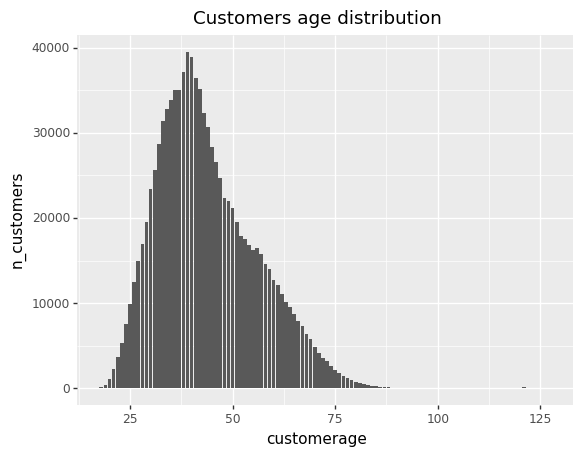

<ggplot: (8744072630533)>

In [22]:
(ggplot(df_customer_data[['customerage']].value_counts().reset_index(name = 'n_customers'), 
        aes(x = 'customerage', y = 'n_customers'))
 + geom_col() 
 + labs(title = "Customers age distribution")
)

### 3.3 What type of customers they are?

* There are not missing values.
* Not pessoa fisicas are a minority class, this can affect the accuracy of the probabilities for this type of customers.


In [24]:
print(f"Percent of observations with NaNs in customer age: {np.round(df_customer_data.pessoa_fisica.isna().mean() * 100, 1)}%")

Percent of observations with NaNs in customer age: 0.0%


In [25]:
df_pessoa = (
    df_customer_data
        .pessoa_fisica
        .value_counts()
        .reset_index()
        .rename(columns = {'index':'pessoa_fisica', 'pessoa_fisica':'n_customers'})
)
df_pessoa

pessoa_fisica  n_customers
0           True      1005432
1          False         9652

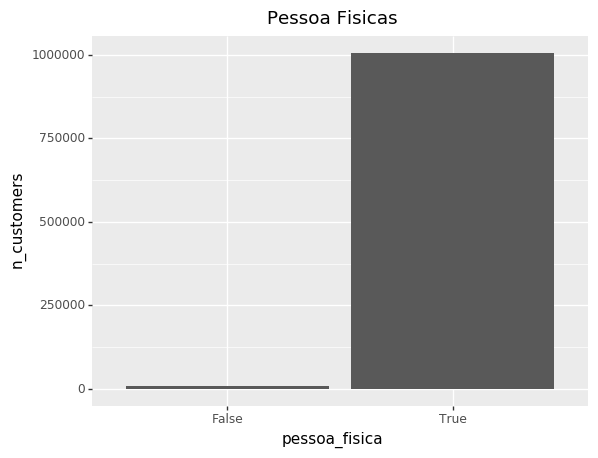

<ggplot: (8744151150461)>

In [26]:
(ggplot(df_pessoa, aes(x = 'pessoa_fisica', y = 'n_customers')) 
     + geom_col() 
     + labs(title = "Pessoa Fisicas")
)

### 3.4 What is the sex and marital status distribution?

**Observations:**

* If this estadocivilid is going to be used it needs to be imputed or create missing variable.
* Sexo id can be imputed with the mode.

In [27]:
print(f"Percent of observations with NaNs in estado civil: {np.round(df_customer_data.estadocivilid.isna().mean() * 100, 1)}%")

Percent of observations with NaNs in estado civil: 30.9%


In [28]:
df_estado_civil = (
    df_customer_data
     .estadocivilid
     .astype('str')
     .replace('nan', "missing")
     .value_counts()
     .reset_index()
     .rename(columns = {'index':'estadocivilid', 'estadocivilid':'n_customers'})
     .sort_values(by = 'estadocivilid')
     .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1))
)
df_estado_civil

estadocivilid  n_customers   pct
2           1.0       204038  20.1
0           2.0       443785  43.7
4           3.0        11279   1.1
3           4.0        36601   3.6
5           5.0         5834   0.6
1       missing       313547  30.9

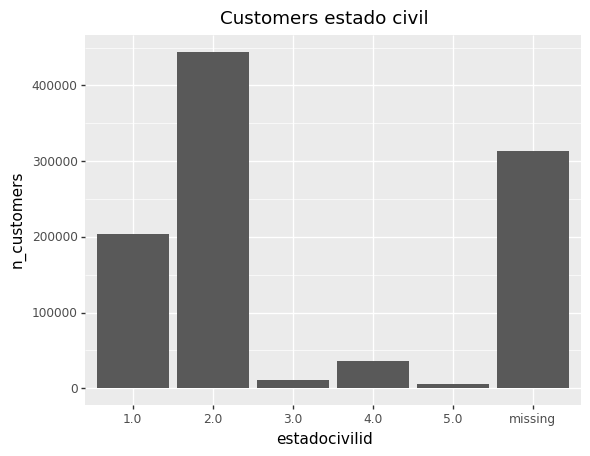

<ggplot: (8782845261797)>

In [21]:
(ggplot(df_estado_civil, aes(x = 'estadocivilid', y = 'n_customers')) 
     + geom_col() 
     + labs(title = "Customers estado civil")
)

In [22]:
print(f"Percent of observations with NaNs in sex: {np.round(df_customer_data.sexoid.isna().mean() * 100, 1)}%")

Percent of observations with NaNs in sex: 1.0%


In [23]:
df_sex = (
    df_customer_data
     .sexoid
     .astype('str')
     .replace('nan', 'missing')
     .value_counts()
     .reset_index()
     .rename(columns = {'index':'sexoid', 'sexoid':'n_customers'})
     .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1)))
df_sex

sexoid  n_customers   pct
0      1.0       819200  80.7
1      2.0       186052  18.3
2  missing         9832   1.0

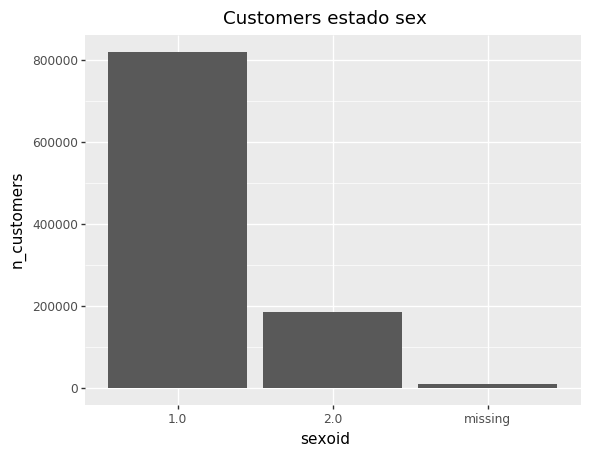

<ggplot: (8782859799149)>

In [24]:
(ggplot(df_sex, aes(x = 'sexoid', y = 'n_customers')) 
     + geom_col() 
     + labs(title = "Customers estado sex")
)

### 3.5 Where are they from?

**Observations**

* In the model the cardinality of the states can be reduced.

In [25]:
df_estado = (
    df_customer_data
        .estado
        .value_counts()
        .reset_index()
        .rename(columns = {'index':'estado', 'estado':'n_customers'})
        .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1))
)
df_estado['estado'] = pd.Categorical(df_estado['estado'],categories = list(df_estado.estado), ordered = True)
df_estado

estado  n_customers   pct
0             São Paulo       649621  64.0
1        Rio de Janeiro       101645  10.0
2          Minas Gerais        67982   6.7
3                Paraná        59209   5.8
4     Rio Grande do Sul        32334   3.2
5        Santa Catarina        24631   2.4
6                 Bahia        18458   1.8
7                 Goiás        11770   1.2
8      Distrito Federal        10642   1.0
9           Mato Grosso         9154   0.9
10           Pernambuco         8730   0.9
11       Espírito Santo         8727   0.9
12   Mato Grosso do Sul         8017   0.8
13                Ceará          891   0.1
14              Alagoas          641   0.1
15                 Pará          542   0.1
16              Paraíba          236   0.0
17            Tocantins          235   0.0
18  Rio Grande do Norte          234   0.0
19             Maranhão          233   0.0
20             Amazonas          232   0.0
21              Sergipe          218   0.0
22             Rondônia          213   0.0
23                 Acre          198   0.0
24                Piauí          126   0.0
25                Amapá          124   0.0
26              Roraima           41   0.0

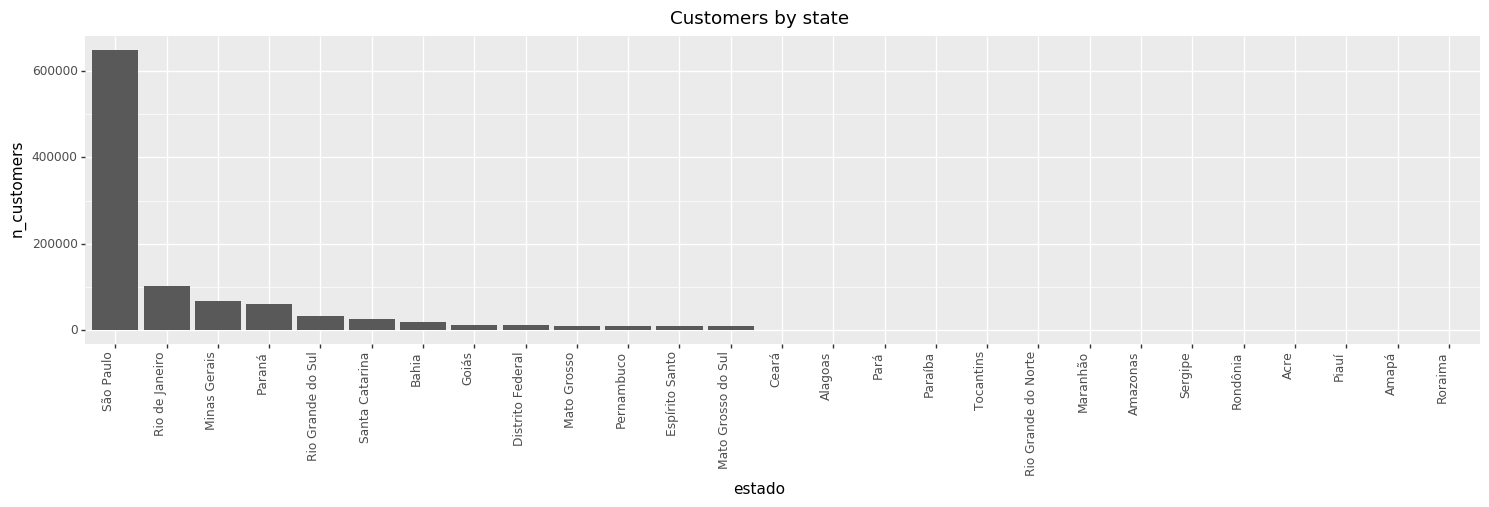

<ggplot: (8782805556189)>

In [26]:
(ggplot( df_estado, aes(x = 'estado', y = 'n_customers') ) 
 + geom_col()
 + labs(title = "Customers by state")
 + theme(
     axis_text_x=element_text(rotation=90, hjust=1), 
     figure_size=(18, 4))
)

----------------

## 4. Financial history exploration<a class="anchor" id="financial-history"></a>

**Observations**

* The financial history aggregates data for customers with transactions since 2019, 2020, 2021.
* Any customer that did not appear in this datset is becuase he/she did not have transactions during this year.



In [29]:
# Defining constants
NUM_YEARS = 3 # Period of yeares in 2019-2021

### 4.1 How many customers have used loans with ConectCar?

**Observations:**

* Those customers that have NaN, is because they have not used a loan to complete a transcation.
* We will build a model for the customers that have had a loan in the last three year period. (187837 - 18.5%)

In [31]:
print(f"Percent of observations with NaNs in total loans: {np.round(df_customer_data.totalloans.isna().mean() * 100, 1)}%")

Percent of observations with NaNs in total loans: 81.5%


In [32]:
df_has_had_loan = (
    df_customer_data
        [['totalloans']]
        .assign(has_had_a_loan = lambda df_: ['no' if np.isnan(val) else 'yes' for val in df_.totalloans])
        .groupby('has_had_a_loan')
        .size()
        .reset_index(name = 'n_customers')
        .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1))
)
df_has_had_loan

has_had_a_loan  n_customers   pct
0             no       827247  81.5
1            yes       187837  18.5

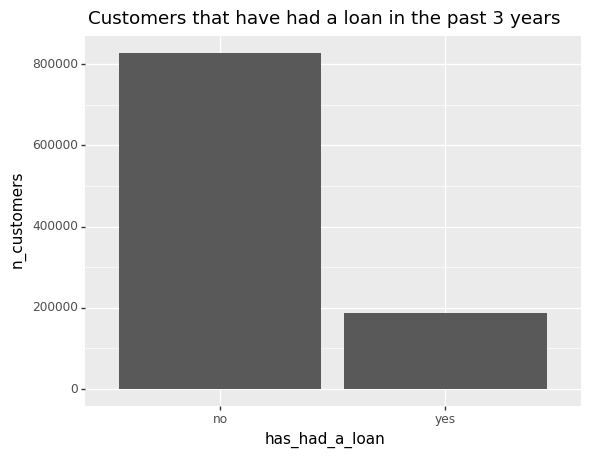

<ggplot: (8744148840153)>

In [33]:
(ggplot( df_has_had_loan, aes(x = 'has_had_a_loan', y = 'n_customers') ) 
     + geom_col() 
     + labs(title = f"Customers that have had a loan in the past {NUM_YEARS} years"))

### 4.2 From those that have had loans in the past, how many they have used?

* 90% of the customers that have requested a loan have used between 1 and 16 loans to complete transactions.
* 50% of our customers have used up to 2 loans.
* 35% of the customers that requested a loan have only used 1.

In [37]:
df_total_loans = (df_customer_data
        .assign(has_had_a_loan = lambda df_: ['no' if np.isnan(val) else 'yes' for val in df_.totalloans])
        .query('has_had_a_loan == "yes"')
        .filter(['totalloans'])
)
df_total_loans.describe(np.arange(.1, 1, .1)).T

count       mean           std  min  10%  20%  30%  40%  50%  \
totalloans  187837.0  83.232436  20649.048903  1.0  1.0  1.0  1.0  2.0  2.0   

            60%  70%  80%   90%        max  
totalloans  3.0  5.0  8.0  16.0  8247505.0

In [38]:
df_total_loans_bin = (
    df_total_loans
     .assign(loans_bin = lambda df_: ['more than 15' if val > 15 else str(int(val)) for val in df_.totalloans])
     .groupby(['loans_bin'])
     .size()
     .reset_index(name = 'n_customers')
     .assign(loans_bin = lambda df_: df_.loans_bin.str.zfill(2))
     .sort_values(by = 'loans_bin')
     .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1)))
df_total_loans_bin

loans_bin  n_customers   pct
0             01        65142  34.7
7             02        29902  15.9
8             03        17735   9.4
9             04        11679   6.2
10            05         8518   4.5
11            06         6937   3.7
12            07         5731   3.1
13            08         4894   2.6
14            09         4148   2.2
1             10         3329   1.8
2             11         2731   1.5
3             12         2368   1.3
4             13         1992   1.1
5             14         1824   1.0
6             15         1550   0.8
15  more than 15        19357  10.3

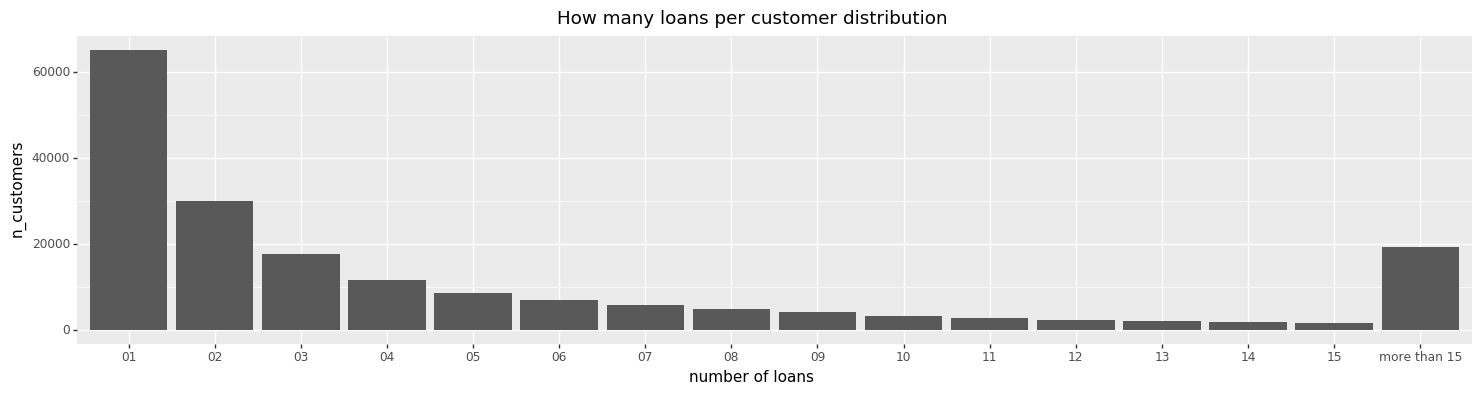

<ggplot: (8744061694709)>

In [39]:
(ggplot(df_total_loans_bin, aes(x = 'loans_bin', y = 'n_customers')) 
 + geom_col() 
 + labs(title = 'How many loans per customer distribution', x = 'number of loans')
 + theme(figure_size=(18, 4))
)

### 4.3 When customers are granted loans how long it took them to repay

**Observations:**

* We can see that 25% of the customers that requested a loan repay on average in the first 2 days.
* We can see that 50% of the customers that requested a loan repay on average in the first 11 days.
* We can see that 75% of the customers that requested a loan repay on average in the first 48 days.
* The more loans, the less days it takes a customer to repay.
* For average payback days, it is a highly skewed distribution, in part because customers that do not use frequently the service have no incentive to repay soon. 
* 99% of our customers have used at most 83 loans to complete highways transactions.
* 99% of our customers have used at most 5 loans to complete parking lot transactions.
* 99% of our customers have used at most 15 loans to complete membership transactions.

**TODO**

* There are a 17% of customers that requested a loan that have registered at least one loan but in the average payback days they register a NaN.

In [40]:
df_loans_and_payback = (df_customer_data
    .assign(has_had_a_loan = lambda df_: ['no' if np.isnan(val) else 'yes' for val in df_.totalloans])
    .query('has_had_a_loan == "yes"')
    .filter(['has_had_a_loan', 'totalloans','avgdayspayback'])
)
df_loans_and_payback

has_had_a_loan  totalloans  avgdayspayback
2                  yes         3.0            70.0
5                  yes         1.0             NaN
8                  yes         8.0             7.0
15                 yes         3.0           203.0
19                 yes         1.0             NaN
...                ...         ...             ...
1015058            yes         4.0           732.0
1015063            yes        27.0            62.0
1015064            yes         1.0           249.0
1015065            yes         6.0            99.0
1015068            yes         3.0             NaN

[187837 rows x 3 columns]

* What is the proportion of customers that have had previous loans during the period and have NaNs in avgdayspayback.

In [41]:
df_na_avgdayspayback = (
    df_loans_and_payback
     .avgdayspayback
     .isna()
     .value_counts()
     .reset_index()
     .rename(columns = {'index':'is_na_avgdayspayback', 'avgdayspayback':'n_customers'})
     .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1))
)
df_na_avgdayspayback

is_na_avgdayspayback  n_customers   pct
0                 False       154948  82.5
1                  True        32889  17.5

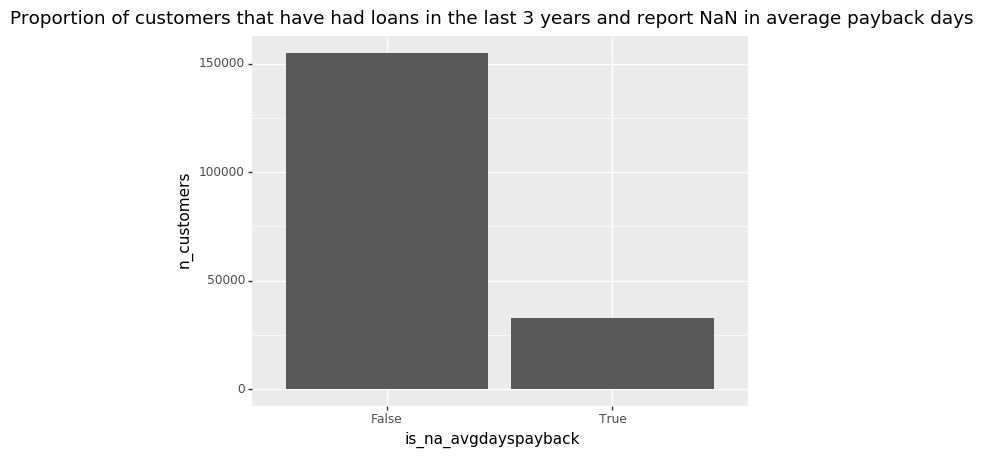

<ggplot: (8782830349269)>

In [37]:
(ggplot(df_na_avgdayspayback, aes(x = 'is_na_avgdayspayback', y = 'n_customers')) 
 + geom_col() 
 + labs(title = f"Proportion of customers that have had loans in the last {NUM_YEARS} years and report NaN in average payback days")
)

* We filter the customers that do not have averagepayback with null values.

In [42]:
df_loans_and_payback = df_loans_and_payback.loc[-np.isnan(df_loans_and_payback.avgdayspayback), :]
df_loans_and_payback

has_had_a_loan  totalloans  avgdayspayback
2                  yes         3.0            70.0
8                  yes         8.0             7.0
15                 yes         3.0           203.0
21                 yes         2.0             1.0
23                 yes        13.0             2.0
...                ...         ...             ...
1015054            yes         6.0            29.0
1015058            yes         4.0           732.0
1015063            yes        27.0            62.0
1015064            yes         1.0           249.0
1015065            yes         6.0            99.0

[154948 rows x 3 columns]

* We can see that 25% of the customers that requested a loan repay on average in the first 2 days.
* We can see that 50% of the customers that requested a loan repay on average in the first 11 days.
* We can see that 75% of the customers that requested a loan repay on average in the first 48 days.

In [50]:
df_loans_and_payback.describe([0.25, 0.6, 0.7, 0.75 ,0.8, 0.9,0.99]).T

count       mean           std  min  25%   50%   60%   70%  \
totalloans      154948.0  99.904645  22735.116974  1.0  1.0   3.0   4.0   6.0   
avgdayspayback  154948.0  52.720351    111.896978  0.0  2.0  11.0  20.0  35.0   

                 75%   80%    90%    99%        max  
totalloans       7.0   9.0   17.0   95.0  8247505.0  
avgdayspayback  48.0  66.0  146.0  602.0     1069.0

In [51]:
q99_totalloans = df_loans_and_payback.totalloans.quantile(0.99)
q99_avgdayspayback = df_loans_and_payback.avgdayspayback.quantile(0.99)

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 367'. Pick better value with 'binwidth'.


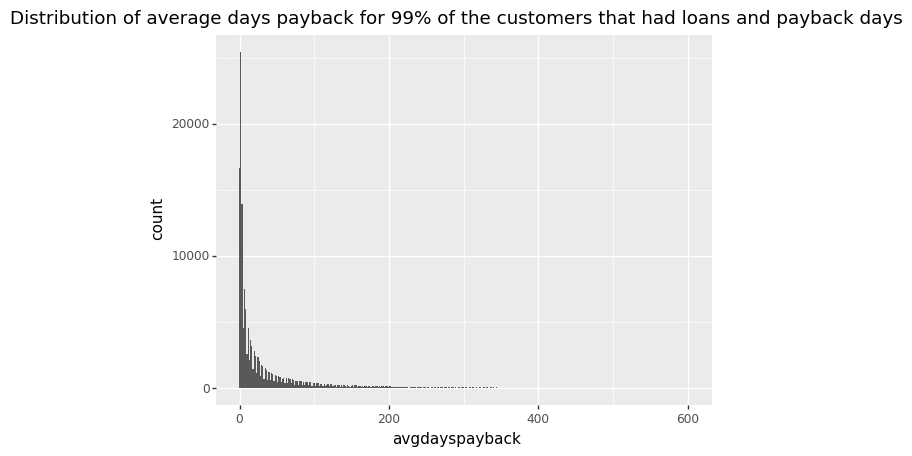

<ggplot: (8744079217073)>

In [52]:
(ggplot(df_loans_and_payback.query('avgdayspayback <= @q99_avgdayspayback'), aes(x = 'avgdayspayback')) 
 + geom_histogram()
 + labs(title = "Distribution of average days payback for 99% of the customers that had loans and payback days")
)

* The more loans, the less days it takes a customer to repay.

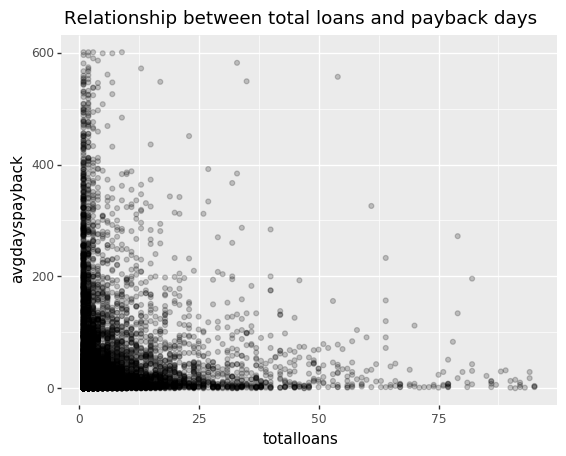

<ggplot: (8744045526553)>

In [53]:
(ggplot(
    df_loans_and_payback.query('avgdayspayback <= @q99_avgdayspayback and totalloans <= @q99_totalloans').sample(10000, random_state = 42),
    aes(x = 'totalloans', y = 'avgdayspayback')) 
 + geom_point(alpha = 0.2)
 + labs(title = 'Relationship between total loans and payback days'))

In [54]:
df_loans_sep = (
    df_customer_data
    [['totalloans', 'totalloans_highway', 'totaloans_parkinglot', 'totalloans_membershipsubscription', 
      'totaltransactions', 'totaltransactions_highway', 'totatransactions_parkinglot', 'totaltransactions_membershipsubscription',
      'avgdayspayback',
      'avaragebalance', 'avaragerecharge', 
      'pessoa_fisica', 
      'sexoid', 
      'nomeplano', 
      'vehicletype', 
      'customerage']]
    .loc[-np.isnan(df_customer_data.avgdayspayback), :]
    .assign(total_loans = lambda df_: df_.totalloans_highway + df_.totaloans_parkinglot + df_.totalloans_membershipsubscription,
            is_equal = lambda df_: np.equal(df_.totalloans, df_.total_loans),
            has_had_a_loan = lambda df_: ['no' if np.isnan(val) else 'yes' for val in df_.totalloans])
    .query('has_had_a_loan == "yes"')

)
df_loans_sep

totalloans  totalloans_highway  totaloans_parkinglot  \
2               3.0                 3.0                   0.0   
8               8.0                 6.0                   0.0   
15              3.0                 3.0                   0.0   
21              2.0                 2.0                   0.0   
23             13.0                13.0                   2.0   
...             ...                 ...                   ...   
1015054         6.0                 5.0                   0.0   
1015058         4.0                 1.0                   0.0   
1015063        27.0                27.0                   0.0   
1015064         1.0                 0.0                   0.0   
1015065         6.0                 5.0                   0.0   

         totalloans_membershipsubscription  totaltransactions  \
2                                      0.0                147   
8                                      0.0                130   
15                                     0.0                 34   
21                                     0.0                 93   
23                                     0.0               1595   
...                                    ...                ...   
1015054                                1.0                 96   
1015058                                2.0                 11   
1015063                                0.0               3993   
1015064                                1.0                 22   
1015065                                1.0               1383   

         totaltransactions_highway  totatransactions_parkinglot  \
2                              142                            1   
8                               91                            0   
15                              34                            0   
21                              61                            0   
23                            1595                           10   
...                            ...                          ...   
1015054                         59                            0   
1015058                          2                            0   
1015063                       3937                           28   
1015064                         18                            0   
1015065                       1311                            3   

         totaltransactions_membershipsubscription  avgdayspayback  \
2                                               0            70.0   
8                                               0             7.0   
15                                              0           203.0   
21                                             31             1.0   
23                                              0             2.0   
...                                           ...             ...   
1015054                                         7            29.0   
1015058                                         5           732.0   
1015063                                        56            62.0   
1015064                                         1           249.0   
1015065                                        65            99.0   

         avaragebalance  avaragerecharge  pessoa_fisica  sexoid  nomeplano  \
2                 65.70           112.50           True     1.0     Básico   
8                 84.24           151.66           True     1.0  Autocarga   
15                17.94            50.00           True     1.0     Básico   
21                36.49            50.00           True     1.0       Flex   
23               119.93           168.97           True     1.0     Básico   
...                 ...              ...            ...     ...        ...   
1015054           35.57            80.00           True     1.0   Completo   
1015058           13.76            50.00           True     2.0   Completo   
1015063          689.92           487.84           True     2.0   Completo   
1015064           50.81          

* 99% of our customers have used at most 83 loans to complete highways transactions.
* 99% of our customers have used at most 5 loans to complete parking lot transactions.
* 99% of our customers have used at most 15 loans to complete membership transactions.

In [58]:
df_loans_sep[['totalloans_highway', 'totaloans_parkinglot', 'totalloans_membershipsubscription']].describe([0.01, 0.1, 0.6, 0.7, 0.8, 0.9, .99]).T

count       mean           std  min  \
totalloans_highway                 154948.0  91.781133  21370.652528  0.0   
totaloans_parkinglot               154948.0   0.668256     73.455554  0.0   
totalloans_membershipsubscription  154948.0   1.300636      3.789820  0.0   

                                    1%  10%  50%  60%  70%  80%   90%   99%  \
totalloans_highway                 0.0  0.0  2.0  3.0  4.0  7.0  14.0  83.0   
totaloans_parkinglot               0.0  0.0  0.0  0.0  0.0  0.0   1.0   5.0   
totalloans_membershipsubscription  0.0  0.0  0.0  1.0  1.0  2.0   3.0  15.0   

                                         max  
totalloans_highway                 7833827.0  
totaloans_parkinglot                 26813.0  
totalloans_membershipsubscription      270.0

* From the customers that have a loan 57% use Completo plano, 18% use Básico and 15% Abastece Aí. The rest of the plans can be aggregated into others.

In [62]:
pd.DataFrame({
    'df_customer_data': df_customer_data.nomeplano.value_counts(normalize = True).round(2),
    'df_loans_sep' : df_loans_sep.nomeplano.value_counts(normalize = True).round(2)
}).sort_values(by = 'df_customer_data', ascending = False)

df_customer_data  df_loans_sep
Completo                          0.59          0.57
Básico                            0.26          0.18
Abastece Aí                       0.09          0.15
Rodovia                           0.02          0.02
Autocarga                         0.01          0.03
Flex                              0.01          0.01
Pré-Pago Empresarial              0.01          0.03
Fiat                              0.00          0.00
Locadora                          0.00          0.00
Pós-Pago Empresarial              0.00          0.00
Urbano                            0.00          0.00

In [63]:
top3_plans = (df_loans_sep.nomeplano.value_counts().index[:3])

In [64]:
(df_loans_sep
     .nomeplano
     .where(
         df_loans_sep
             .nomeplano
             .isin(top3_plans), 
         other = 'Other')
     .value_counts(normalize = True))

Completo       0.566532
Básico         0.181267
Abastece Aí    0.150360
Other          0.101841
Name: nomeplano, dtype: float64

In [65]:
df_loans_sep2 = (df_loans_sep
    .assign(nomeplano_groups = lambda df_: df_.nomeplano.where( df_.nomeplano.isin(top3_plans), other = 'Other'))
    .assign(customerage_cut = lambda df_: pd.qcut(df_.customerage, q = 5))
    .assign(customerage_cutstr = lambda df_: df_.customerage_cut.astype('str'))
)
df_loans_sep2

totalloans  totalloans_highway  totaloans_parkinglot  \
2               3.0                 3.0                   0.0   
8               8.0                 6.0                   0.0   
15              3.0                 3.0                   0.0   
21              2.0                 2.0                   0.0   
23             13.0                13.0                   2.0   
...             ...                 ...                   ...   
1015054         6.0                 5.0                   0.0   
1015058         4.0                 1.0                   0.0   
1015063        27.0                27.0                   0.0   
1015064         1.0                 0.0                   0.0   
1015065         6.0                 5.0                   0.0   

         totalloans_membershipsubscription  totaltransactions  \
2                                      0.0                147   
8                                      0.0                130   
15                                     0.0                 34   
21                                     0.0                 93   
23                                     0.0               1595   
...                                    ...                ...   
1015054                                1.0                 96   
1015058                                2.0                 11   
1015063                                0.0               3993   
1015064                                1.0                 22   
1015065                                1.0               1383   

         totaltransactions_highway  totatransactions_parkinglot  \
2                              142                            1   
8                               91                            0   
15                              34                            0   
21                              61                            0   
23                            1595                           10   
...                            ...                          ...   
1015054                         59                            0   
1015058                          2                            0   
1015063                       3937                           28   
1015064                         18                            0   
1015065                       1311                            3   

         totaltransactions_membershipsubscription  avgdayspayback  \
2                                               0            70.0   
8                                               0             7.0   
15                                              0           203.0   
21                                             31             1.0   
23                                              0             2.0   
...                                           ...             ...   
1015054                                         7            29.0   
1015058                                         5           732.0   
1015063                                        56            62.0   
1015064                                         1           249.0   
1015065                                        65            99.0   

         avaragebalance  avaragerecharge  pessoa_fisica  sexoid  nomeplano  \
2                 65.70           112.50           True     1.0     Básico   
8                 84.24           151.66           True     1.0  Autocarga   
15                17.94            50.00           True     1.0     Básico   
21                36.49            50.00           True     1.0       Flex   
23               119.93           168.97           True     1.0     Básico   
...                 ...              ...            ...     ...        ...   
1015054           35.57            80.00           True     1.0   Completo   
1015058           13.76            50.00           True     2.0   Completo   
1015063          689.92           487.84           True     2.0   Completo   
1015064           50.81          

### 4.4 Behaviour of customers that use loans to complete highway transactions

**Observations:**

* Most no pessoa fisicas are in Other plans and in general they use Pesado vehicles, non the less they are present in all vehicle categories
* Other plans show the most heteoreneous behavior in terms of average days to pay
* Altough females are less in the customers database, they show the same patterns as males in average days to payback and total loans.
* Pesado vehicles show more noise in average days to pay back.
* Pesado vehicles and Other plans are the ones with more null values in customer age.

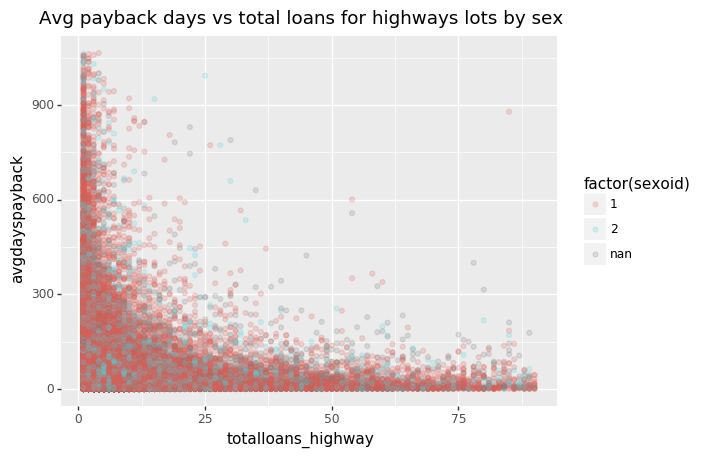

<ggplot: (8744155749277)>

In [66]:
(ggplot(df_loans_sep
            .query('totalloans_highway > 0 and totalloans_highway <= 90'), 
        aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'factor(sexoid)')) 
 + geom_point(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for highways lots by sex")
)

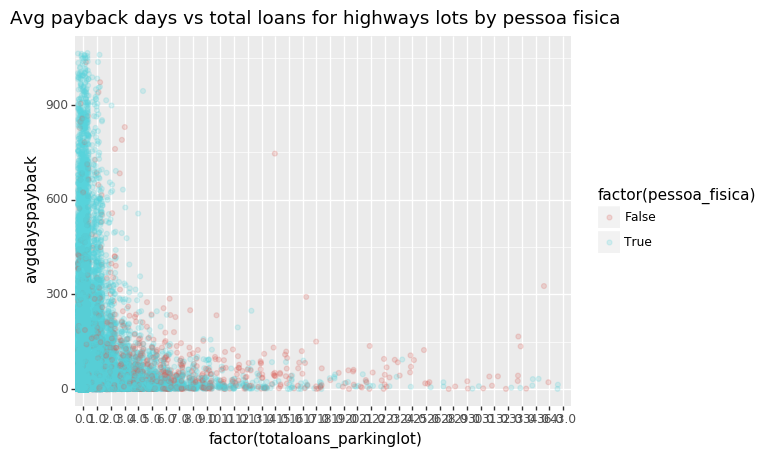

<ggplot: (8744148848861)>

In [67]:
(ggplot(
    df_loans_sep
        .query('totalloans_highway > 0 and totalloans_highway <= 90'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'factor(pessoa_fisica)')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for highways lots by pessoa fisica")
)

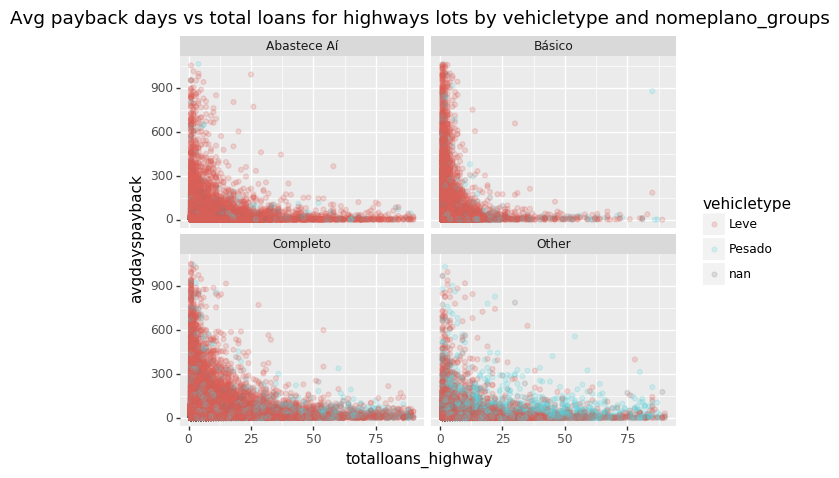

<ggplot: (8744099117401)>

In [68]:
(ggplot(df_loans_sep2
            .query('totalloans_highway > 0 and totalloans_highway <= 90'), 
        aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'vehicletype')) 
 + geom_point(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for highways lots by vehicletype and nomeplano_groups")
 + facet_wrap('nomeplano_groups')
)

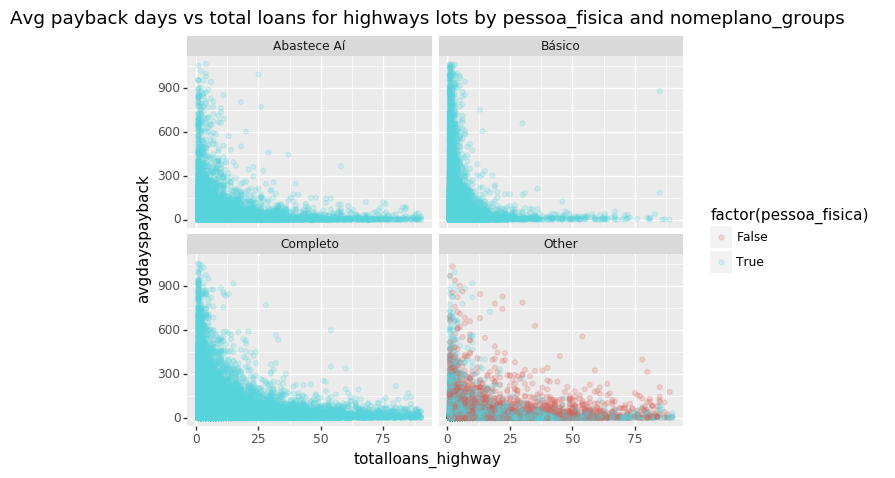

<ggplot: (8744125772205)>

In [69]:
(ggplot(df_loans_sep2
            .query('totalloans_highway > 0 and totalloans_highway <= 90'), 
        aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'factor(pessoa_fisica)')) 
 + geom_point(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for highways lots by pessoa_fisica and nomeplano_groups")
 + facet_wrap('nomeplano_groups')
)

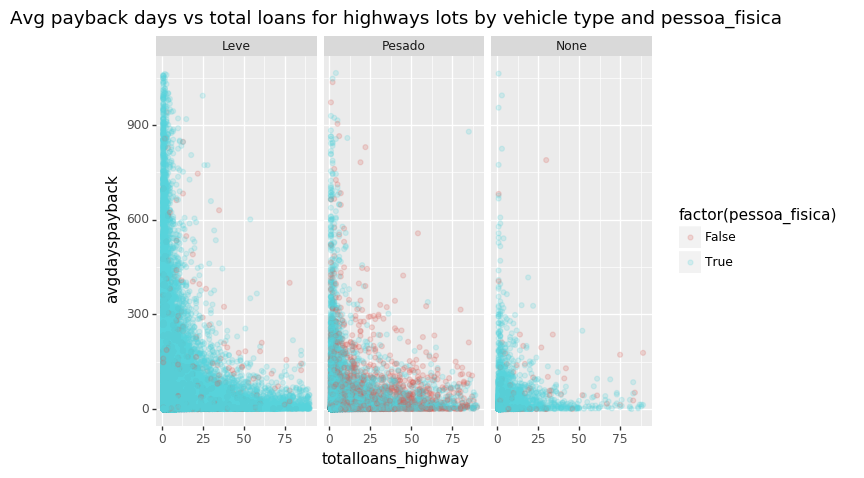

<ggplot: (8744107963845)>

In [70]:
(ggplot(df_loans_sep2
            .query('totalloans_highway > 0 and totalloans_highway <= 90'), 
        aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'factor(pessoa_fisica)')) 
 + geom_point(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for highways lots by vehicle type and pessoa_fisica")
 + facet_wrap('vehicletype')
)

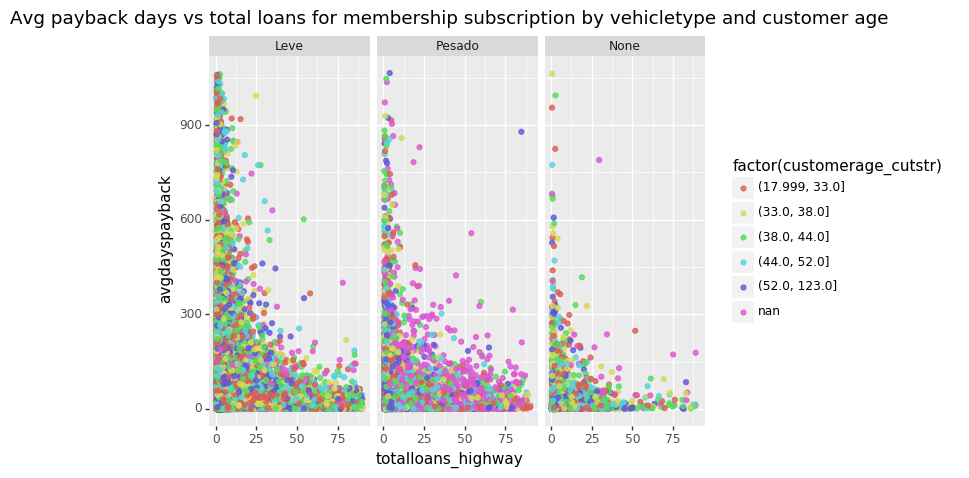

<ggplot: (8744090530869)>

In [71]:
(ggplot(
    df_loans_sep2
        .query('totalloans_highway > 0 and totalloans_highway <= 90'),
    aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'factor(customerage_cutstr)')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('vehicletype')
 + labs(title = "Avg payback days vs total loans for membership subscription by vehicletype and customer age")
)

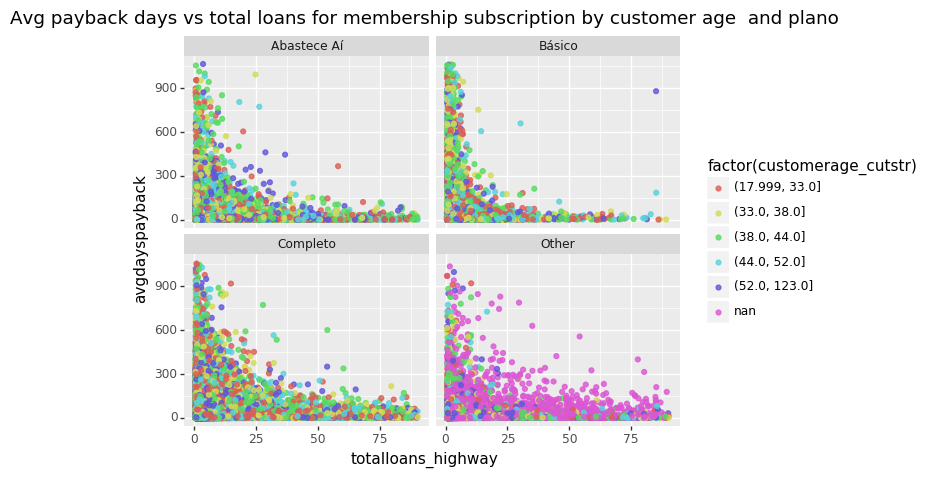

<ggplot: (8744086162205)>

In [72]:
(ggplot(
    df_loans_sep2
        .query('totalloans_highway > 0 and totalloans_highway <= 90'),
    aes(x = 'totalloans_highway', y = 'avgdayspayback', color = 'factor(customerage_cutstr)')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('nomeplano_groups')
 + labs(title = "Avg payback days vs total loans for membership subscription by customer age  and plano")
)

### 4.5 Behaviour of customers that use loans to complete Parking lots

* Most clients (90%) have requested up to 5 parking lot loans to complete their transactions.
* The more loans they request the more it takes them to repay on average.
* The noisiest group are the ones that request their first loan
* In terms of null values others and pesado vehicles are the ones that account the most.
* Users with Basic plano are the ones that request more loans for parking lots, and the ones that show more average days to repay loans.

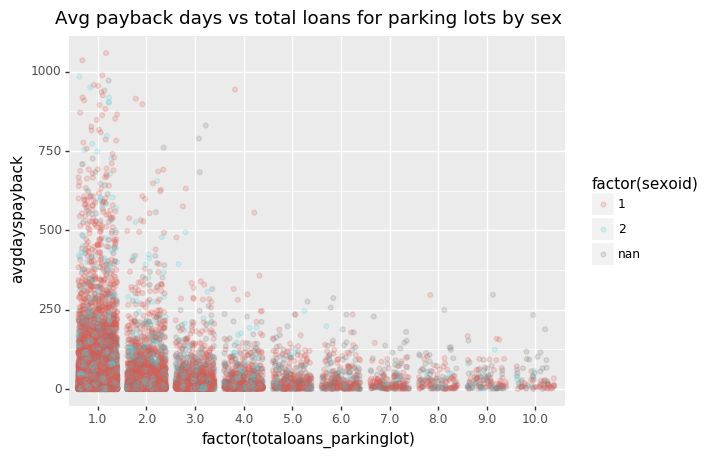

<ggplot: (8744057231249)>

In [73]:
(ggplot(
    df_loans_sep.query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'factor(sexoid)')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for parking lots by sex"))

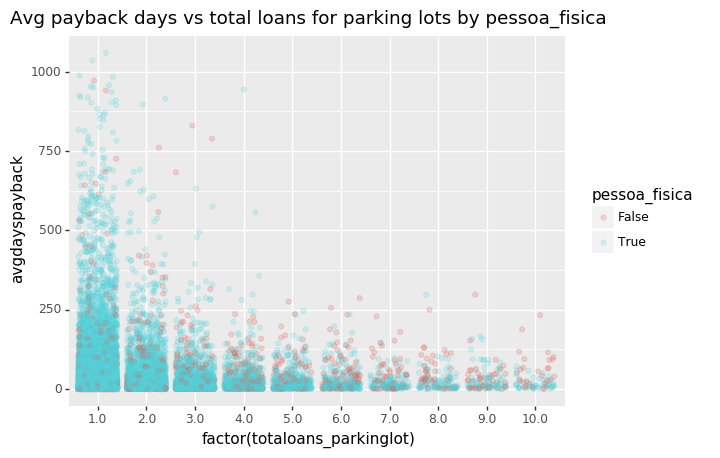

<ggplot: (8744084270585)>

In [74]:
(ggplot(
    df_loans_sep.query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for parking lots by pessoa_fisica")
)

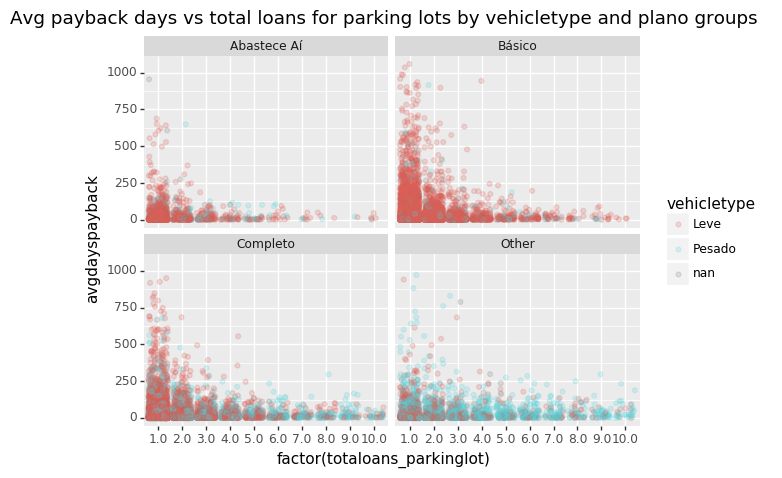

<ggplot: (8744086162185)>

In [75]:
(ggplot(
    df_loans_sep2.query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'vehicletype')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for parking lots by vehicletype and plano groups")
 + facet_wrap('nomeplano_groups')
)

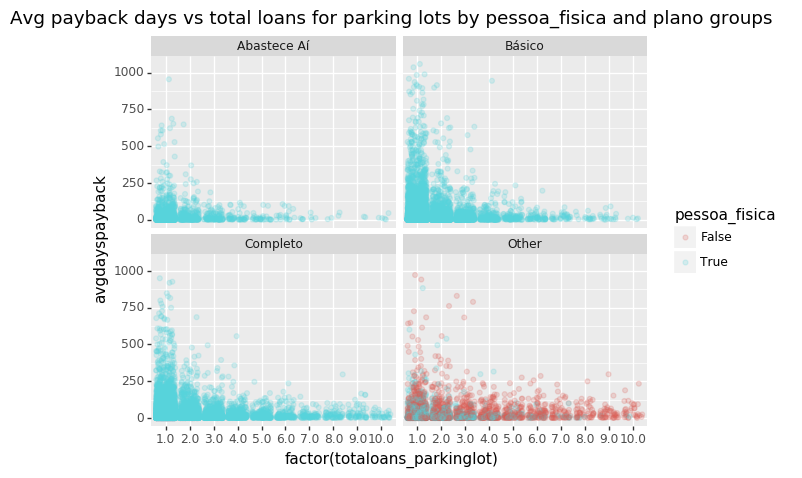

<ggplot: (8744151150453)>

In [76]:
(ggplot(
    df_loans_sep2.query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for parking lots by pessoa_fisica and plano groups")
 + facet_wrap('nomeplano_groups')
)

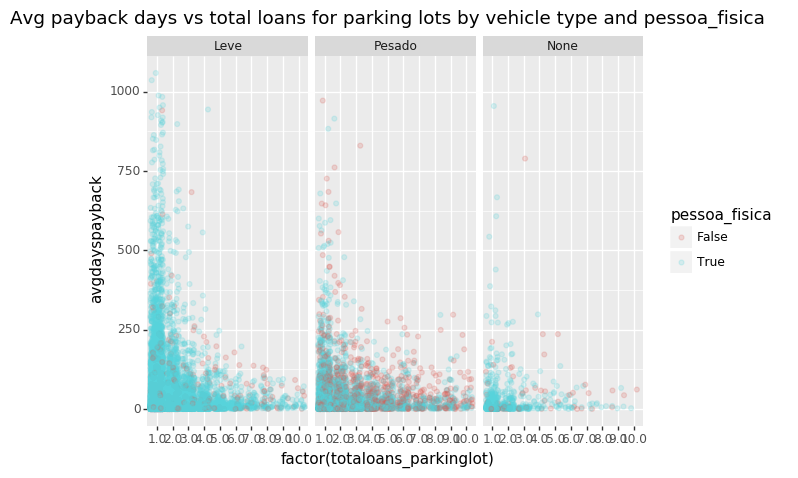

<ggplot: (8744142122245)>

In [77]:
(ggplot(
    df_loans_sep2.query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'), 
    aes(x = 'factor(totaloans_parkinglot)', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for parking lots by vehicle type and pessoa_fisica")
 + facet_wrap('vehicletype')
)


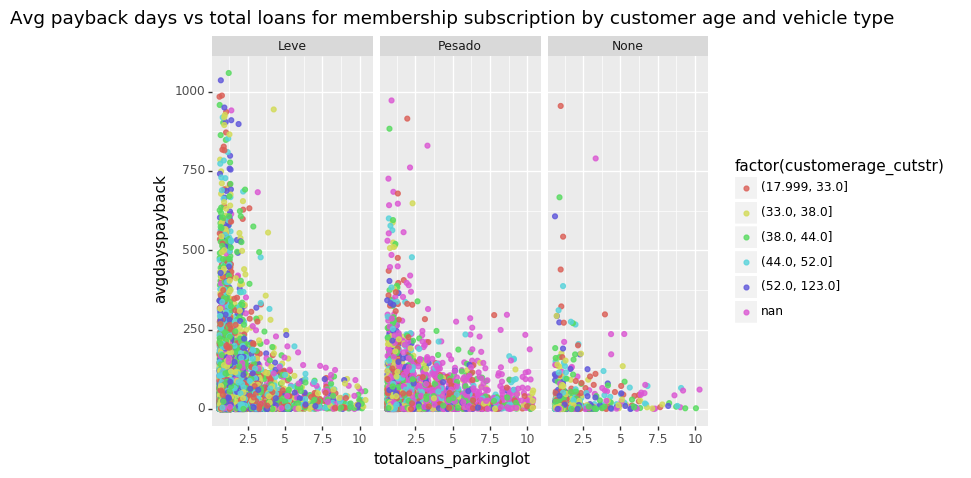

<ggplot: (8744138357005)>

In [78]:
(ggplot(
    df_loans_sep2
        .query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'),
    aes(x = 'totaloans_parkinglot', y = 'avgdayspayback', color = 'factor(customerage_cutstr)')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('vehicletype')
 + labs(title = "Avg payback days vs total loans for membership subscription by customer age and vehicle type")
)

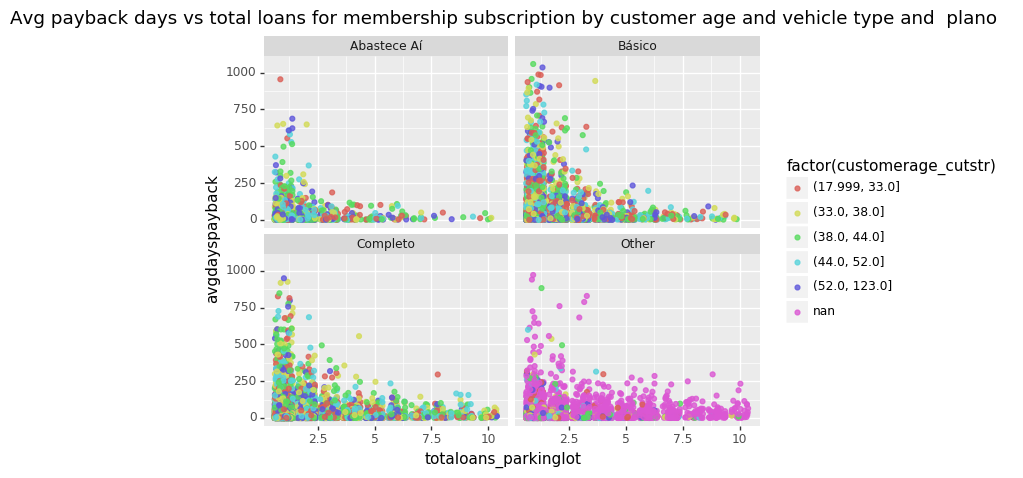

<ggplot: (8744141894521)>

In [79]:
(ggplot(
    df_loans_sep2
        .query('totaloans_parkinglot > 0 and totaloans_parkinglot <= 10'),
    aes(x = 'totaloans_parkinglot', y = 'avgdayspayback', color = 'factor(customerage_cutstr)')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('nomeplano_groups')
 + labs(title = "Avg payback days vs total loans for membership subscription by customer age and vehicle type and  plano")
)

### 4.6 Behaviour of customers that use loans to complete Membership

**Observations:**

* 99% of the customers that request a loan take up to 15 memership subcriptions loans to complete their transactions.
* Abastece Aí and Completo are the plans that request it the most. 
* In the Others plans it is the no pessoa fisica that request it the most and the ones that show more noise in terms of payback days.

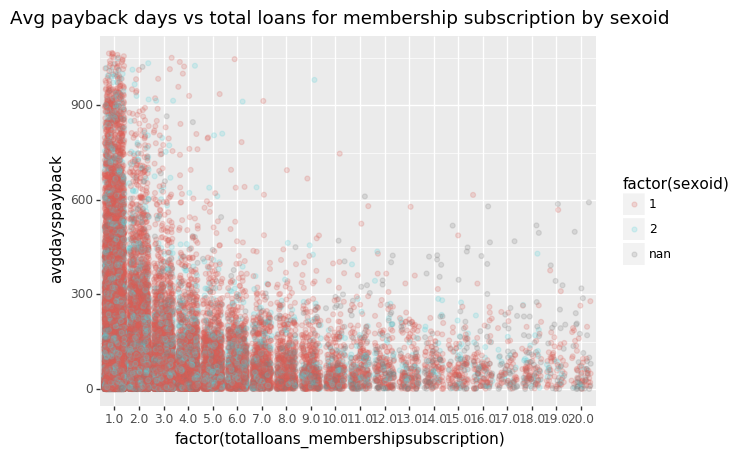

<ggplot: (8782842688033)>

In [63]:
(ggplot(
    df_loans_sep
        .query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'factor(totalloans_membershipsubscription)', y = 'avgdayspayback', color = 'factor(sexoid)')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for membership subscription by sexoid"))

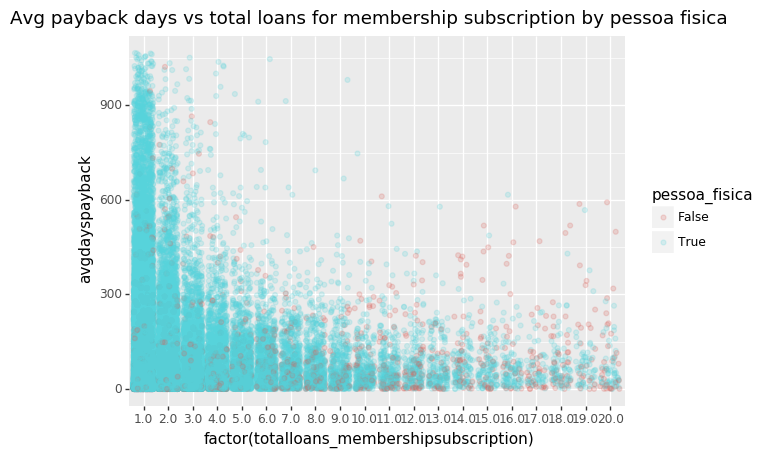

<ggplot: (8782755216825)>

In [64]:
(ggplot(
    df_loans_sep
        .query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'factor(totalloans_membershipsubscription)', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + labs(title = "Avg payback days vs total loans for membership subscription by pessoa fisica")
)

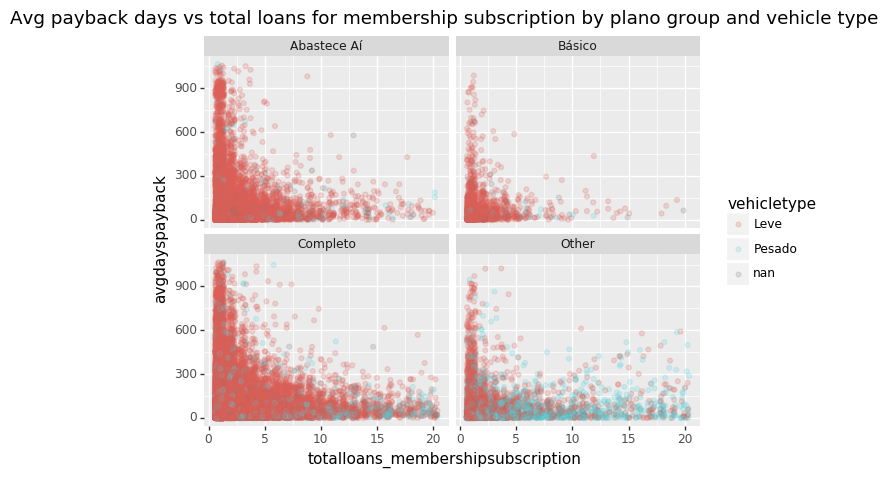

<ggplot: (8782752971721)>

In [65]:
(ggplot(
    df_loans_sep2.query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'totalloans_membershipsubscription', y = 'avgdayspayback', color = 'vehicletype')) 
 + geom_jitter(alpha = 0.2)
 + facet_wrap('nomeplano_groups')
 + labs(title = "Avg payback days vs total loans for membership subscription by plano group and vehicle type")
)

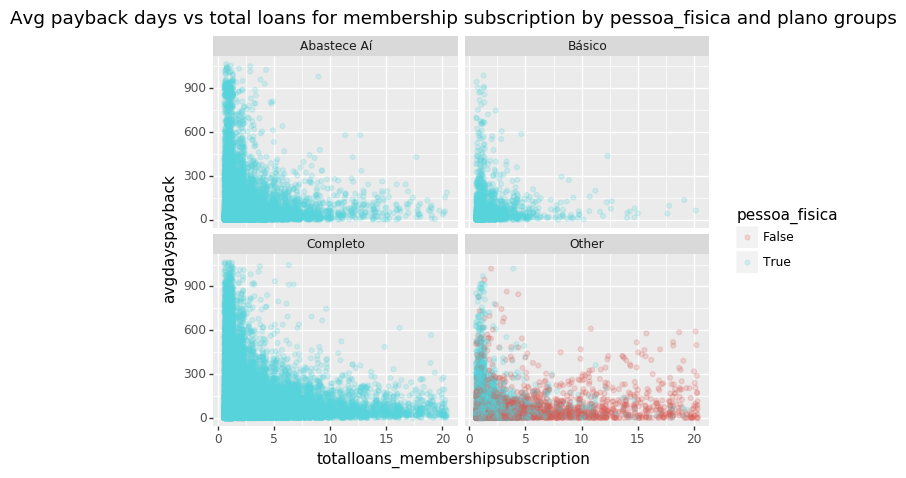

<ggplot: (8782752471197)>

In [66]:
(ggplot(
    df_loans_sep2.query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'totalloans_membershipsubscription', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + facet_wrap('nomeplano_groups')
 + labs(title = "Avg payback days vs total loans for membership subscription by pessoa_fisica and plano groups")
)

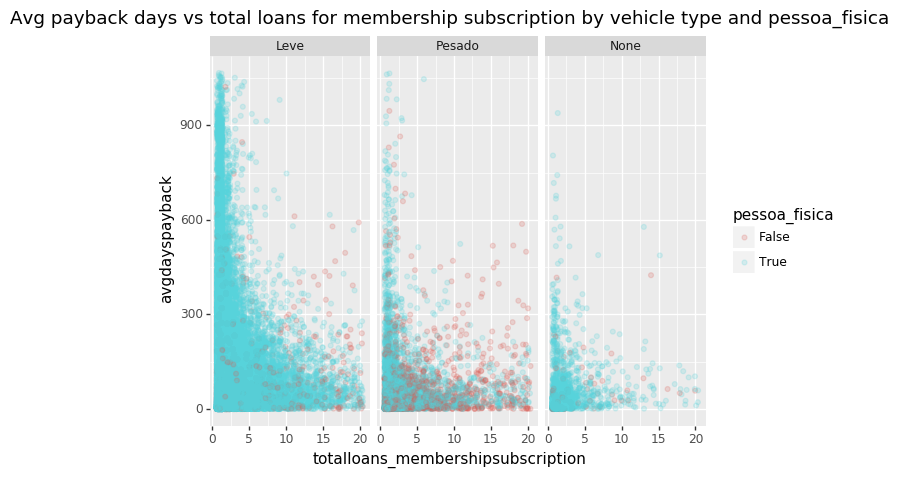

<ggplot: (8782788891069)>

In [67]:
(ggplot(
    df_loans_sep2.query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'totalloans_membershipsubscription', y = 'avgdayspayback', color = 'pessoa_fisica')) 
 + geom_jitter(alpha = 0.2)
 + facet_wrap('vehicletype')
 + labs(title = "Avg payback days vs total loans for membership subscription by vehicle type and pessoa_fisica")
)

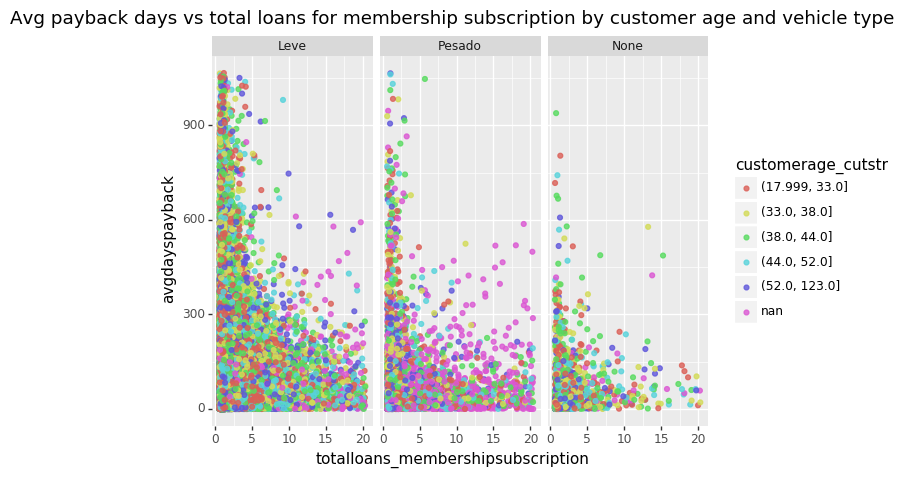

<ggplot: (8782785250265)>

In [68]:
(ggplot(
    df_loans_sep2
        .query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'),
    aes(x = 'totalloans_membershipsubscription', y = 'avgdayspayback', color = 'customerage_cutstr')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('vehicletype')
 + labs(title = "Avg payback days vs total loans for membership subscription by customer age and vehicle type")
)

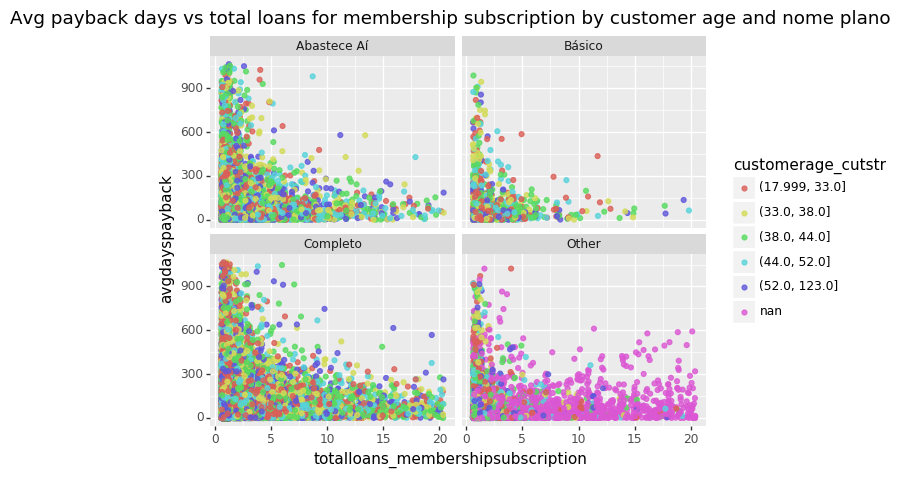

<ggplot: (8782805568757)>

In [69]:
(ggplot(
    df_loans_sep2
        .query('totalloans_membershipsubscription > 0 and totalloans_membershipsubscription <= 20'), 
    aes(x = 'totalloans_membershipsubscription', y = 'avgdayspayback', color = 'customerage_cutstr')) 
 + geom_jitter(alpha = .8)
 + facet_wrap('nomeplano_groups')
 + labs(title = "Avg payback days vs total loans for membership subscription by customer age and nome plano")
)

### 4.7 What is the balance and recharge behaviour?

**Observations**

* From the customers that used at least a loan, their averagebalance ranges between -11 and 879 Brazilian reals (median = 56)
* From the customers that used at least a loan, their averagerecharge ranges between 42 and 750 Brazilian reals (median = 71)
* From the customers that used at least a loan, their total transaction range between 2 and 5594 (median = 208)
* From the customers that used at least a loan, their total loans range between 1 and 95 (median = 3)

TODO: 

* Average recharge, there are some customers that register 3883 missing values.

In [71]:
df_loans_sep2[['avaragebalance', 'avaragerecharge', 'totaltransactions', 'totalloans']].describe([0.01, 0.25, 0.5, 0.75, 0.9, 0.99]).T

count        mean           std          min       1%  \
avaragebalance     154948.0 -121.477788  48721.611518 -13855709.58 -11.5553   
avaragerecharge    151065.0  119.577917    574.571890         0.00  42.5000   
totaltransactions  154948.0  698.058394  23264.001365         1.00   2.0000   
totalloans         154948.0   99.904645  22735.116974         1.00   1.0000   

                     25%     50%       75%     90%        99%         max  
avaragebalance     42.44   55.55   77.2625  122.79   879.0244   115956.95  
avaragerecharge    51.61   70.83  100.0000  163.57   750.0000    97131.14  
totaltransactions  94.00  208.00  440.0000  905.00  5594.5300  8247512.00  
totalloans          1.00    3.00    7.0000   17.00    95.0000  8247505.00

In [72]:
df_loans_sep2[['avaragebalance', 'avaragerecharge', 'totaltransactions', 'totalloans']].isna().sum()

avaragebalance          0
avaragerecharge      3883
totaltransactions       0
totalloans              0
dtype: int64

### 4.8 What is the balance of the customers that use loans?

**Observations:**

- 89% of the customers have a balance between 11 and 125 BRL.
- The most frequent recharges are 50 and 100 BRL.

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 121'. Pick better value with 'binwidth'.


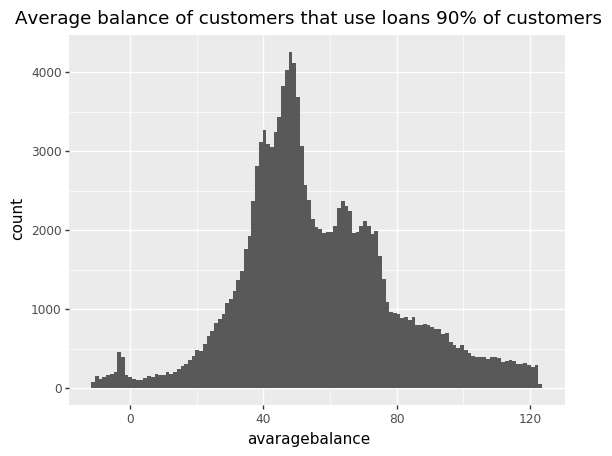

<ggplot: (8744133952277)>

In [81]:
q01_avaragebalance = df_loans_sep2.avaragebalance.quantile(0.01)
q99_avaragebalance = df_loans_sep2.avaragebalance.quantile(0.90)
(ggplot(
    df_loans_sep2.query('avaragebalance > @q01_avaragebalance and avaragebalance < @q99_avaragebalance'), 
    aes(x = 'avaragebalance')) 
 + geom_histogram()
 + labs(title = "Average balance of customers that use loans 90% of customers")
)

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 66'. Pick better value with 'binwidth'.


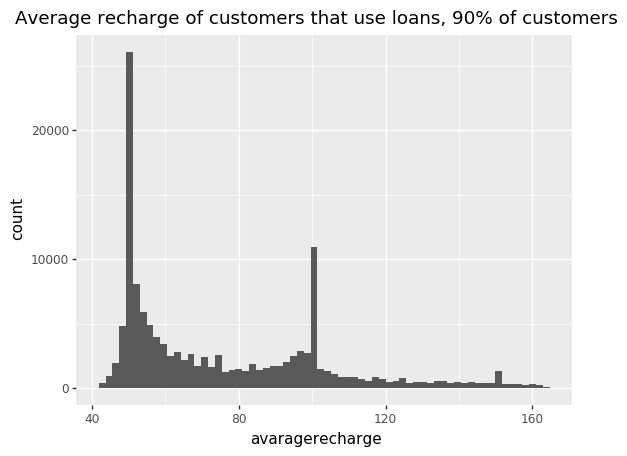

<ggplot: (8744133878357)>

In [82]:
q01_avaragerecharge = df_loans_sep2.avaragerecharge.quantile(0.01)
q99_avaragerecharge = df_loans_sep2.avaragerecharge.quantile(0.90)
(ggplot(
    df_loans_sep2.query('avaragerecharge > @q01_avaragerecharge and avaragerecharge < @q99_avaragerecharge'), 
    aes(x = 'avaragerecharge')) 
 + geom_histogram()
 + labs(title = "Average recharge of customers that use loans, 90% of customers")
)

In [83]:
# 'totaltransactions', 'totalloans'
df_loans_average_balance_recharge = (
    df_loans_sep2
        .filter(['nomeplano_groups', 
                 'vehicletype', 
                 'pessoa_fisica', 
                 'customerage_cutstr', 
                 'avaragebalance', 
                 'avaragerecharge' ])
        .query('avaragebalance > @q01_avaragebalance and avaragebalance < @q99_avaragebalance and avaragerecharge > @q01_avaragerecharge and avaragerecharge < @q99_avaragerecharge')
)
df_loans_average_balance_recharge

nomeplano_groups vehicletype  pessoa_fisica customerage_cutstr  \
2                 Básico        Leve           True       (38.0, 44.0]   
8                  Other        Leve           True       (44.0, 52.0]   
15                Básico        Leve           True       (33.0, 38.0]   
21                 Other        Leve           True      (52.0, 123.0]   
26                 Other        Leve           True      (52.0, 123.0]   
...                  ...         ...            ...                ...   
1015053         Completo        Leve           True     (17.999, 33.0]   
1015054         Completo        Leve           True     (17.999, 33.0]   
1015058         Completo        Leve           True       (33.0, 38.0]   
1015064         Completo        Leve           True       (33.0, 38.0]   
1015065         Completo        Leve           True      (52.0, 123.0]   

         avaragebalance  avaragerecharge  
2                 65.70           112.50  
8                 84.24           151.66  
15                17.94            50.00  
21                36.49            50.00  
26                28.08            78.52  
...                 ...              ...  
1015053           40.93            49.16  
1015054           35.57            80.00  
1015058           13.76            50.00  
1015064           50.81           100.00  
1015065           56.47            52.16  

[130394 rows x 6 columns]

In [84]:
df_loans_average_balance_recharge_long = (
    df_loans_average_balance_recharge
        .melt(id_vars = ['nomeplano_groups', 'vehicletype', 'pessoa_fisica', 'customerage_cutstr'])
)
df_loans_average_balance_recharge_long

nomeplano_groups vehicletype  pessoa_fisica customerage_cutstr  \
0                Básico        Leve           True       (38.0, 44.0]   
1                 Other        Leve           True       (44.0, 52.0]   
2                Básico        Leve           True       (33.0, 38.0]   
3                 Other        Leve           True      (52.0, 123.0]   
4                 Other        Leve           True      (52.0, 123.0]   
...                 ...         ...            ...                ...   
260783         Completo        Leve           True     (17.999, 33.0]   
260784         Completo        Leve           True     (17.999, 33.0]   
260785         Completo        Leve           True       (33.0, 38.0]   
260786         Completo        Leve           True       (33.0, 38.0]   
260787         Completo        Leve           True      (52.0, 123.0]   

               variable   value  
0        avaragebalance   65.70  
1        avaragebalance   84.24  
2        avaragebalance   17.94  
3        avaragebalance   36.49  
4        avaragebalance   28.08  
...                 ...     ...  
260783  avaragerecharge   49.16  
260784  avaragerecharge   80.00  
260785  avaragerecharge   50.00  
260786  avaragerecharge  100.00  
260787  avaragerecharge   52.16  

[260788 rows x 6 columns]

**Observations:**
    
* There is a pattern of 50 and 100 BRZ balances across al plans.
* Basic plans have a wide range of balance, also others.

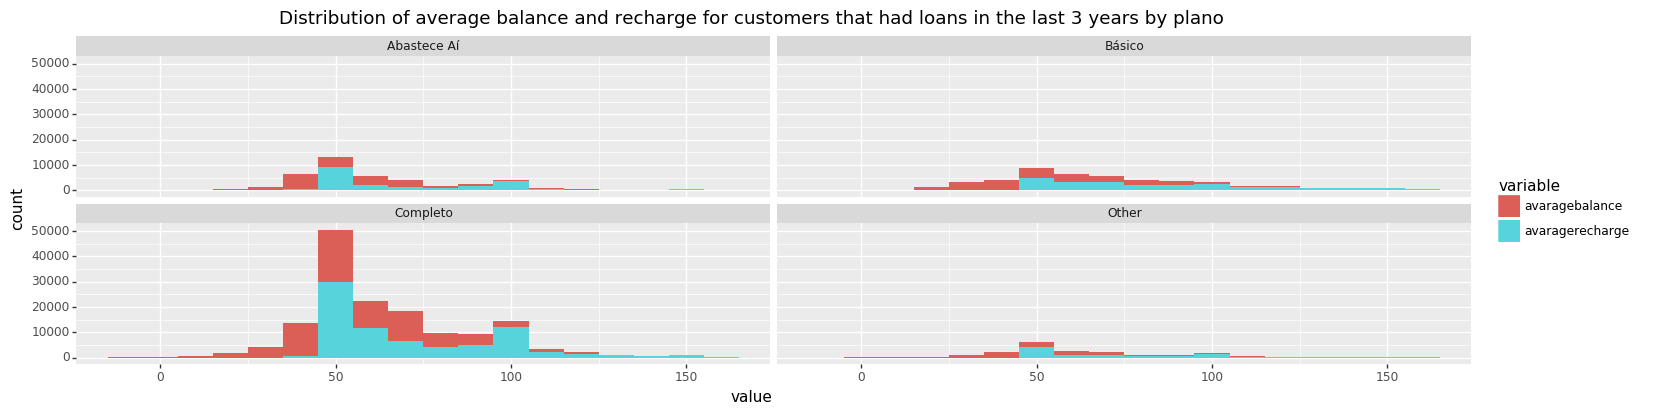

<ggplot: (8744140186741)>

In [85]:
(ggplot(df_loans_average_balance_recharge_long, 
        aes( x = 'value', fill = 'variable')) 
 + geom_histogram(binwidth = 10) 
 + facet_wrap('nomeplano_groups')
 + labs(title = f"Distribution of average balance and recharge for customers that had loans in the last {NUM_YEARS} years by plano")
 + theme(figure_size=(18, 4)))

**Observations:**
    
   - There are few observations in terms of pesado vehicles and None, this can be difficult to predict.
   - Probably we should remove them.

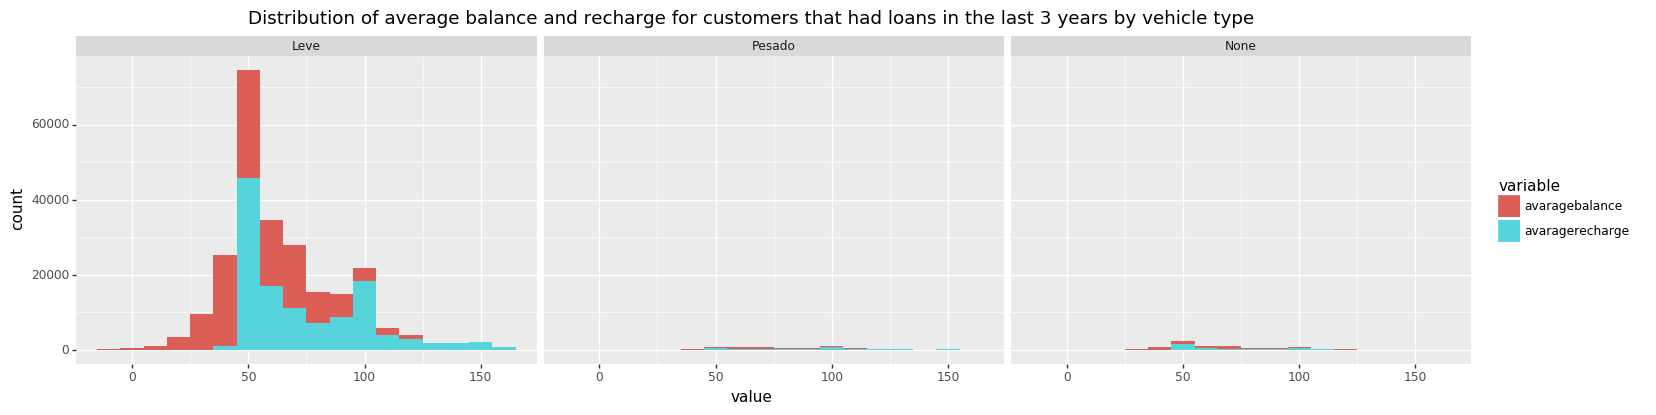

<ggplot: (8744115193137)>

In [86]:
(ggplot(df_loans_average_balance_recharge_long, 
        aes( x = 'value', fill = 'variable')) 
 + geom_histogram(binwidth = 10) 
 + facet_wrap('vehicletype')
 + labs(title = f"Distribution of average balance and recharge for customers that had loans in the last {NUM_YEARS} years by vehicle type")
 + theme(figure_size=(18, 4)))

**Observations:**
    
  * There are very few observations of no pessoa fisicas, it would be diffiult to predict something. There is not even good information on average balance and recharge for this category.

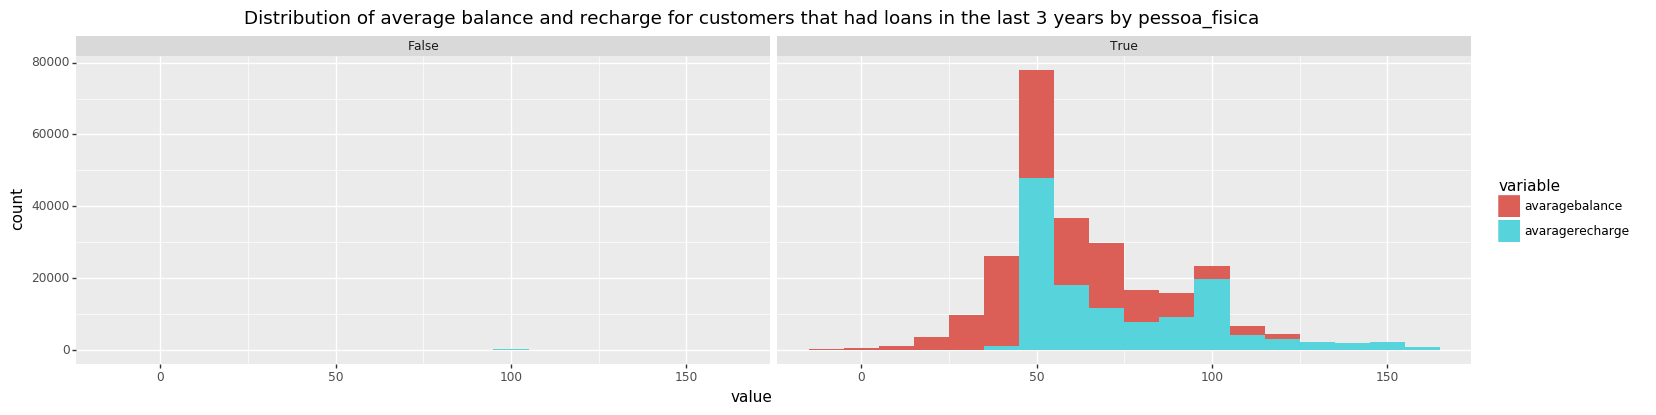

<ggplot: (8744072938461)>

In [87]:
(ggplot(df_loans_average_balance_recharge_long, 
        aes( x = 'value', fill = 'variable')) 
 + geom_histogram(binwidth = 10) 
 + facet_wrap('pessoa_fisica')
 + labs(title = f"Distribution of average balance and recharge for customers that had loans in the last {NUM_YEARS} years by pessoa_fisica")
 + theme(figure_size=(18, 4)))

**Observations:**
  * There is not a clear pattern in terms of age.

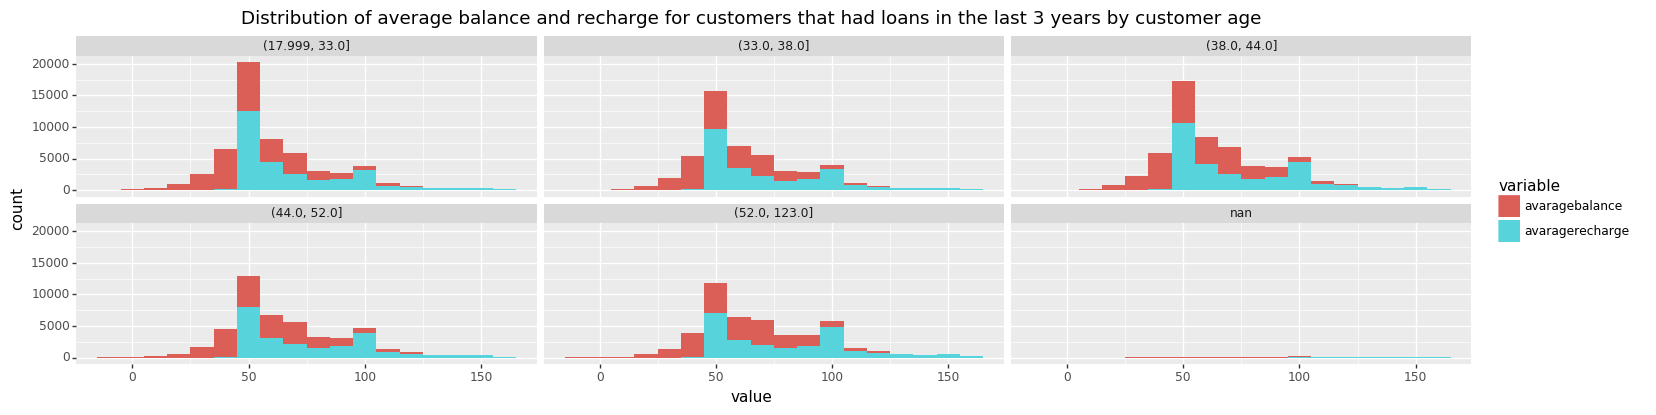

<ggplot: (8744073394957)>

In [88]:
(ggplot(df_loans_average_balance_recharge_long, 
        aes( x = 'value', fill = 'variable')) 
 + geom_histogram(binwidth = 10) 
 + facet_wrap('customerage_cutstr')
 + labs(title = f"Distribution of average balance and recharge for customers that had loans in the last {NUM_YEARS} years by customer age")
 + theme(figure_size=(18, 4)))

In [89]:
df_loans_average_balance_recharge

nomeplano_groups vehicletype  pessoa_fisica customerage_cutstr  \
2                 Básico        Leve           True       (38.0, 44.0]   
8                  Other        Leve           True       (44.0, 52.0]   
15                Básico        Leve           True       (33.0, 38.0]   
21                 Other        Leve           True      (52.0, 123.0]   
26                 Other        Leve           True      (52.0, 123.0]   
...                  ...         ...            ...                ...   
1015053         Completo        Leve           True     (17.999, 33.0]   
1015054         Completo        Leve           True     (17.999, 33.0]   
1015058         Completo        Leve           True       (33.0, 38.0]   
1015064         Completo        Leve           True       (33.0, 38.0]   
1015065         Completo        Leve           True      (52.0, 123.0]   

         avaragebalance  avaragerecharge  
2                 65.70           112.50  
8                 84.24           151.66  
15                17.94            50.00  
21                36.49            50.00  
26                28.08            78.52  
...                 ...              ...  
1015053           40.93            49.16  
1015054           35.57            80.00  
1015058           13.76            50.00  
1015064           50.81           100.00  
1015065           56.47            52.16  

[130394 rows x 6 columns]

**Observations:**

* There is not much difference in balance and recharge patterns among customer age.
* There is a difference in patterns among balance and recharge patterns accross plans.
    - In general completo plans have higher balances and less recharges that basicos.
    - Abastece ahi and other are all over the place.
* Pessoas no fiscas and customer age have the same recharge and balance patterns. Probably we need to filter them.

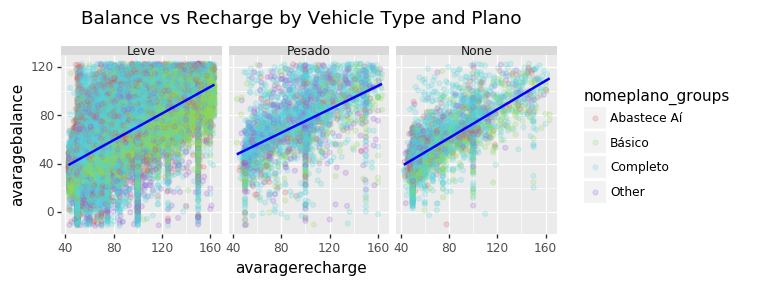

<ggplot: (8744076460957)>

In [91]:
(ggplot(df_loans_average_balance_recharge, 
        aes( x = 'avaragerecharge', y = 'avaragebalance', color = 'nomeplano_groups')) 
 + geom_point(alpha = 0.2)
 + geom_smooth(color = 'blue')
 + coord_equal()
 + facet_wrap('vehicletype')
 + labs(title = 'Balance vs Recharge by Vehicle Type and Plano')
)

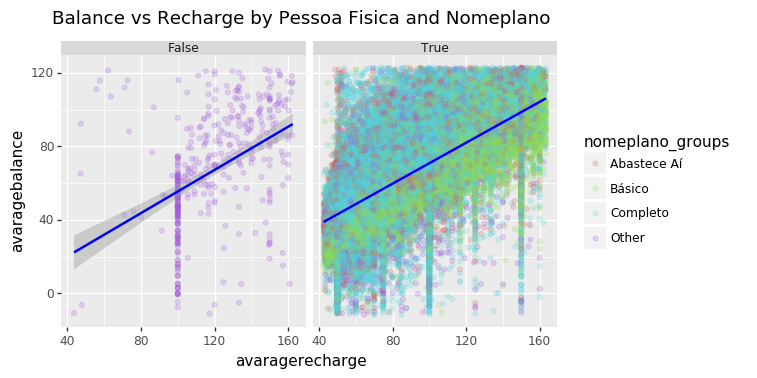

<ggplot: (8744150418981)>

In [92]:
(ggplot(df_loans_average_balance_recharge, 
        aes( x = 'avaragerecharge', y = 'avaragebalance', color = 'nomeplano_groups')) 
 + geom_point(alpha = 0.2)
 + geom_smooth(color = 'blue')
 + coord_equal()
 + facet_wrap('pessoa_fisica')
 + labs(title = 'Balance vs Recharge by Pessoa Fisica and Nomeplano')
)

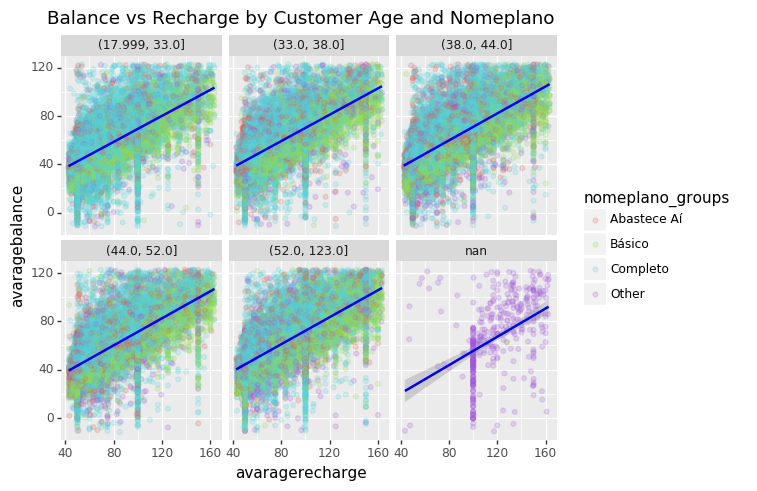

<ggplot: (8744114479525)>

In [93]:
(ggplot(df_loans_average_balance_recharge, 
        aes( x = 'avaragerecharge', y = 'avaragebalance', color = 'nomeplano_groups')) 
 + geom_point(alpha = 0.2)
 + geom_smooth(color = 'blue')
 + facet_wrap('customerage_cutstr')
 + coord_equal()
 + labs(title = 'Balance vs Recharge by Customer Age and Nomeplano')

)

### 4.9 Loans vs Transactions

**Observations:**

* The customers that have more transactions, have more loans and they tend to have lower average payback days.
* Completo and Abastece Aí are the plans that are the noisiest to repay. Much of this noise comes from the customers with the most transactions.

In [95]:
# 'totaltransactions', 'totalloans'
df_loans_balance_recharge_transactions = (
    df_loans_sep2
        .filter(['nomeplano_groups', 
                 'vehicletype', 
                 'pessoa_fisica', 
                 'customerage_cutstr', 
                 'avaragebalance', 
                 'avaragerecharge',
                 'avgdayspayback',
                 'totaltransactions', 
                 'totalloans'])
        .query('avaragebalance > @q01_avaragebalance and avaragebalance < @q99_avaragebalance and avaragerecharge > @q01_avaragerecharge and avaragerecharge < @q99_avaragerecharge')
)
df_loans_balance_recharge_transactions

nomeplano_groups vehicletype  pessoa_fisica customerage_cutstr  \
2                 Básico        Leve           True       (38.0, 44.0]   
8                  Other        Leve           True       (44.0, 52.0]   
15                Básico        Leve           True       (33.0, 38.0]   
21                 Other        Leve           True      (52.0, 123.0]   
26                 Other        Leve           True      (52.0, 123.0]   
...                  ...         ...            ...                ...   
1015053         Completo        Leve           True     (17.999, 33.0]   
1015054         Completo        Leve           True     (17.999, 33.0]   
1015058         Completo        Leve           True       (33.0, 38.0]   
1015064         Completo        Leve           True       (33.0, 38.0]   
1015065         Completo        Leve           True      (52.0, 123.0]   

         avaragebalance  avaragerecharge  avgdayspayback  totaltransactions  \
2                 65.70           112.50            70.0                147   
8                 84.24           151.66             7.0                130   
15                17.94            50.00           203.0                 34   
21                36.49            50.00             1.0                 93   
26                28.08            78.52            19.0                261   
...                 ...              ...             ...                ...   
1015053           40.93            49.16            58.0                163   
1015054           35.57            80.00            29.0                 96   
1015058           13.76            50.00           732.0                 11   
1015064           50.81           100.00           249.0                 22   
1015065           56.47            52.16            99.0               1383   

         totalloans  
2               3.0  
8               8.0  
15              3.0  
21              2.0  
26             40.0  
...             ...  
1015053         3.0  
1015054         6.0  
1015058         4.0  
1015064         1.0  
1015065         6.0  

[130394 rows x 9 columns]

In [96]:
df_loans_balance_recharge_transactions.describe([0.99]).T

count        mean         std    min      50%      99%  \
avaragebalance     130394.0   56.571268   21.190928 -11.55   52.345   114.82   
avaragerecharge    130394.0   74.496368   27.002595  42.59   63.840   151.53   
avgdayspayback     130394.0   44.164778   92.401853   0.00   10.000   475.00   
totaltransactions  130394.0  329.135482  471.590098   1.00  199.000  2079.00   
totalloans         130394.0    7.076207   18.343224   1.00    3.000    68.00   

                        max  
avaragebalance       122.78  
avaragerecharge      163.47  
avgdayspayback      1062.00  
totaltransactions  55478.00  
totalloans          1360.00

In [97]:
q99_avaragebalance = df_loans_balance_recharge_transactions.avaragebalance.quantile(0.99)
q99_totalloans = df_loans_balance_recharge_transactions.totalloans.quantile(0.99)
q99_avgdayspayback = df_loans_balance_recharge_transactions.avgdayspayback.quantile(0.99)

In [98]:
df_loans_balance_recharge_transactions.totaltransactions.describe()

count    130394.000000
mean        329.135482
std         471.590098
min           1.000000
25%          97.000000
50%         199.000000
75%         392.000000
max       55478.000000
Name: totaltransactions, dtype: float64

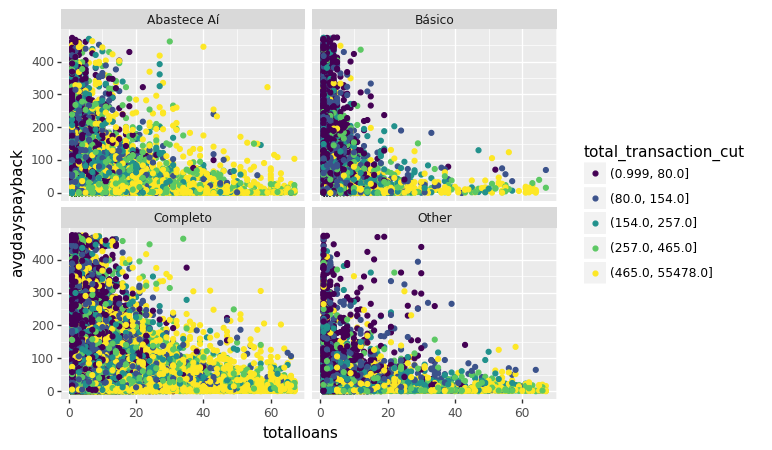

<ggplot: (8744114481561)>

In [99]:
(ggplot(
    df_loans_balance_recharge_transactions
        .query('avgdayspayback < @q99_avgdayspayback and totalloans < @q99_totalloans')
        .assign(total_transaction_cut = pd.qcut(df_loans_balance_recharge_transactions.totaltransactions, q = 5)), 
    aes(x = 'totalloans', y = 'avgdayspayback', color = 'total_transaction_cut')) 
 + geom_point()
 + facet_wrap('nomeplano_groups'))

----------

## 5. Last Transaction Exploration <a class="anchor" id="last-transactions"></a>


### 5.1 How many customers generated a loan from ConectCar to complete their transaction? 

* For clarification. 
    - YES means they have still money in their account. 
    - NO means they no longer have money in their account.
    
**Observations**:

* On their last transaction:
    - 87% of the customers did not requested a loan.
    - 8% requested a loan and have not repaid it.
    - 5% requested a loan and already repaid it.

In [101]:
(df_customer_data
     .groupby(['hadcreditavailabel', 'doesstillhasdebit'])
     .size()
     .sort_values(ascending=False)
     .reset_index(name = 'n_obs')
     .assign(pct = lambda df_ : np.round(df_.n_obs / df_.n_obs.sum(),3) * 100))

hadcreditavailabel                      doesstillhasdebit   n_obs   pct
0                YES  HAD NO DEBITS ON HIS LAST TRANSACTION  884614  87.1
1                 NO                                     NO   83711   8.2
2                 NO                                    YES   46759   4.6

In [103]:
df_last_transaction = (
    df_customer_data
        .loc[-np.isnan(df_customer_data.avgdayspayback), :]
        .assign(total_loans = lambda df_: df_.totalloans_highway + df_.totaloans_parkinglot + df_.totalloans_membershipsubscription,
                is_equal = lambda df_: np.equal(df_.totalloans, df_.total_loans),
                has_had_a_loan = lambda df_: ['no' if np.isnan(val) else 'yes' for val in df_.totalloans])
        .query('has_had_a_loan == "yes"')
        .groupby(['hadcreditavailabel', 'doesstillhasdebit'])
        .size()
        .sort_values(ascending=False)
        .reset_index(name = 'n_obs')
        .assign(pct = lambda df_ : np.round(df_.n_obs / df_.n_obs.sum(),3) * 100))

### 5.2 How many of the customers that generated a loan repaid and how many have not paid yet?



* From those that generated a loan 65% already paid and 35% have not.

In [112]:
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['hadcreditavailabel', 'doesstillhasdebit'])
     .size()
     .sort_values(ascending=False)
     .reset_index(name = 'n_obs')
     .assign(pct = lambda df_ : np.round(df_.n_obs / df_.n_obs.sum(),3) * 100)
)

hadcreditavailabel doesstillhasdebit  n_obs   pct
0                 NO                NO  83711  64.2
1                 NO               YES  46759  35.8

### 5.3 How much money was lent?

* Total amount of money lent to customers.

In [107]:
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['hadcreditavailabel', 'doesstillhasdebit'])
     ['lasttransactionvalue']
     .sum()
     .sort_values(ascending=False)
     .reset_index(name = 'amount_lent')
     .assign(pct = lambda df_ : np.round(df_.amount_lent / df_.amount_lent.sum(),3) * 100))

hadcreditavailabel doesstillhasdebit  amount_lent   pct
0                 NO                NO    997329.22  60.2
1                 NO               YES    658819.53  39.8

### 5.4 From customers that still owe money for ConectCar, how many days have they remain in delinquency?

**Observations**:

* In the last transaction 50% of the customers more than 365 days owing.
* This does not make much sense in comparison to the average days payback. Altough there must be customers that last transaction ocurred in 2019.


TODO:

* Verify that this calculation in SQL is correct.

In [115]:
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['hadcreditavailabel', 'doesstillhasdebit'])
     ['daysowningloan']
     .describe(percentiles = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
)

count        mean         std  min  \
hadcreditavailabel doesstillhasdebit                                         
NO                 NO                 83711.0  500.364767  319.630191  1.0   
                   YES                46759.0  472.191984  362.068889  1.0   

                                        1%   10%    20%    30%    40%    50%  \
hadcreditavailabel doesstillhasdebit                                           
NO                 NO                 13.0  75.0  158.0  265.0  356.0  488.0   
                   YES                 1.0   9.0   31.0  165.0  301.0  470.0   

                                        60%    70%    80%    90%     99%  \
hadcreditavailabel doesstillhasdebit                                       
NO                 NO                 628.0  715.0  830.0  951.0  1070.0   
                   YES                659.0  756.0  858.0  951.0  1069.0   

                                         max  
hadcreditavailabel doesstillhasdebit          
NO                 NO                 1080.0  
                   YES                1080.0

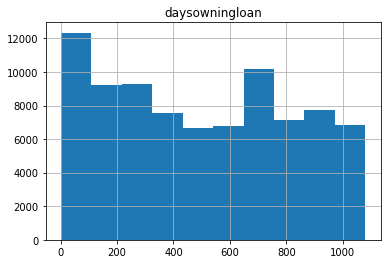

In [116]:
(df_customer_data
     .query('hadcreditavailabel=="NO" and doesstillhasdebit=="NO"')
     .filter(['daysowningloan'])
     .hist());

### 5.5 From the customers that have not yet paid, how many are within the first 15 days threshold, and how many we could say defaulted?

**Observations**:

* Only 2% of customers in their last transaction repaid within the first 15 days.

In [117]:
def fun_classify_days_owning_loan( row ):
    '''Function to classify days of owning a 
    loan in categorical variables'''
    days = row['daysowningloan']
    if days <= 15:
        return 'first_15_days'
    elif days <= 30:
        return 'first_30_days'
    elif days <= 60:
        return 'first_60_days'
    elif days <= 180:
        return 'first_180_days'
    else:
        return 'more_than_180_days'

In [121]:
df_delinquency_days_cut = (df_customer_data
     .query('hadcreditavailabel=="NO" and doesstillhasdebit=="NO"')
     .assign(delinquency_days_cut = lambda row : row.apply(fun_classify_days_owning_loan, axis = 1),
             delinquency_days_cut_ord = lambda df_ : pd.Categorical(df_.delinquency_days_cut, ordered=True, categories=['first_15_days', 'first_30_days', 'first_60_days', 'first_180_days', 'more_than_180_days']))
     .groupby(['delinquency_days_cut_ord'])
     .size())

df_delinquency_days_summary = df_delinquency_days_cut.reset_index(name = 'n_obs').assign(
    pct = lambda df_ : np.round(df_.n_obs / df_.n_obs.sum(), 2) * 100,
    cum_sum = lambda df_ : df_.n_obs.cumsum(),
    pct_cum_sum = lambda df_ :  np.round(df_.cum_sum / df_.cum_sum.sum(), 2) * 100
)

df_delinquency_days_summary

delinquency_days_cut_ord  n_obs   pct  cum_sum  pct_cum_sum
0            first_15_days   2218   3.0     2218          2.0
1            first_30_days    203   0.0     2421          2.0
2            first_60_days   3763   4.0     6184          5.0
3           first_180_days  12569  15.0    18753         17.0
4       more_than_180_days  64958  78.0    83711         74.0

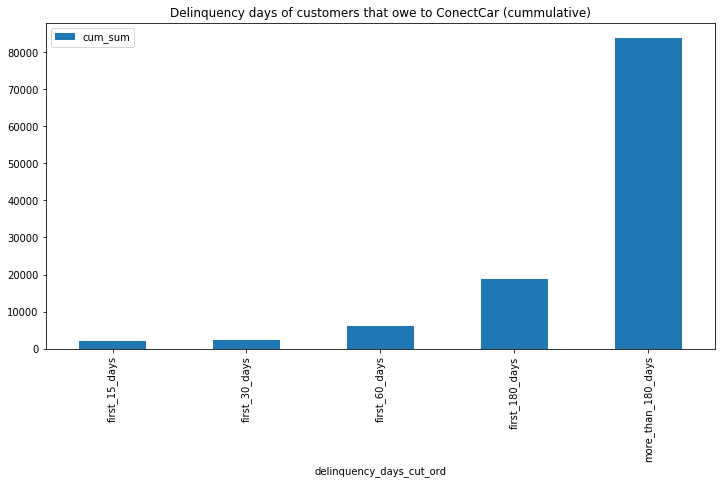

In [122]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_delinquency_days_summary[['delinquency_days_cut_ord', 'cum_sum']]
     .plot(x = 'delinquency_days_cut_ord', y = 'cum_sum', kind = 'bar', ax = ax)

)
plt.title("Delinquency days of customers that owe to ConectCar (cummulative)")
plt.show()

### 5.6 Are there any patterns of delinquency in terms of plan?

In [125]:
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'nomeplano'])
     .size()
)

doesstillhasdebit  nomeplano           
NO                 Abastece Aí             13292
                   Autocarga                 627
                   Básico                  24110
                   Completo                40326
                   Fiat                        1
                   Flex                      816
                   Locadora                    1
                   Pré-Pago Empresarial     2386
                   Pós-Pago Empresarial      100
                   Rodovia                  1588
                   Urbano                    456
YES                Abastece Aí              5175
                   Autocarga                 793
                   Básico                  12791
                   Completo                25652
                   Fiat                        6
                   Flex                      451
                   Pré-Pago Empresarial      644
                   Pós-Pago Empresarial        8
                   Rodovia   

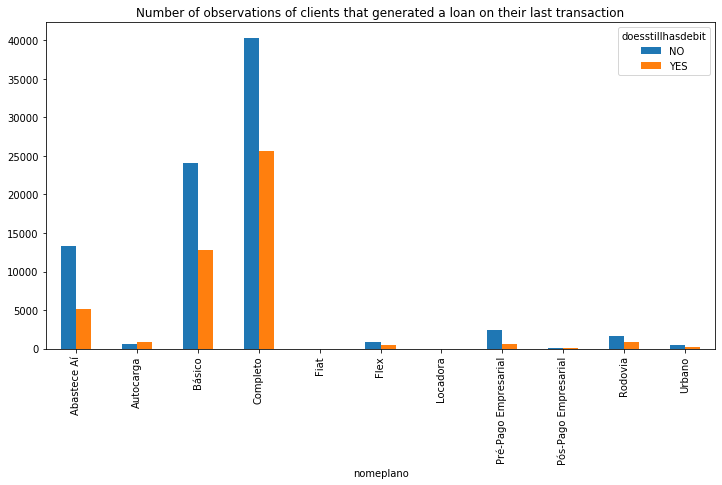

In [126]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'nomeplano'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'nomeplano', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction")
plt.show()

* What is abastece aí
* Autorecarga
+ Básico
* Completo

### 5.7 Is there any pattern by age in terms of defaulting?

* People between 30 and 50 tend to accumulate more loans.
* People older than 50 tend to owe less.

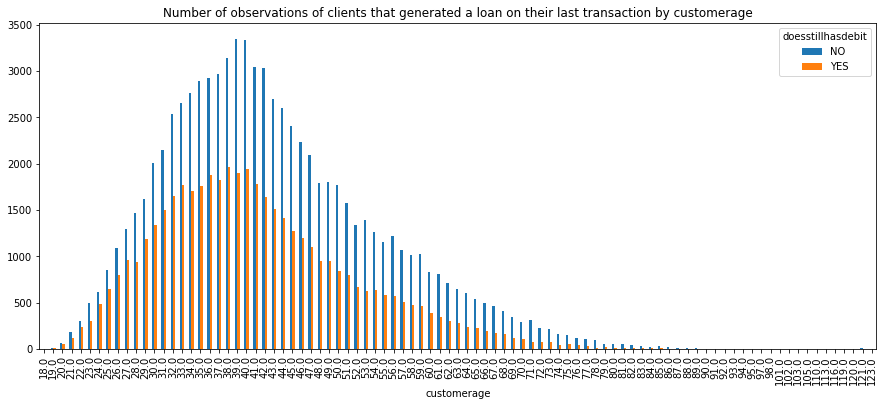

In [127]:
fig, ax = plt.subplots(figsize = (15, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'customerage'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'customerage', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction by customerage")
plt.show()

### 5.8 Is there any pattern in vehicle type?

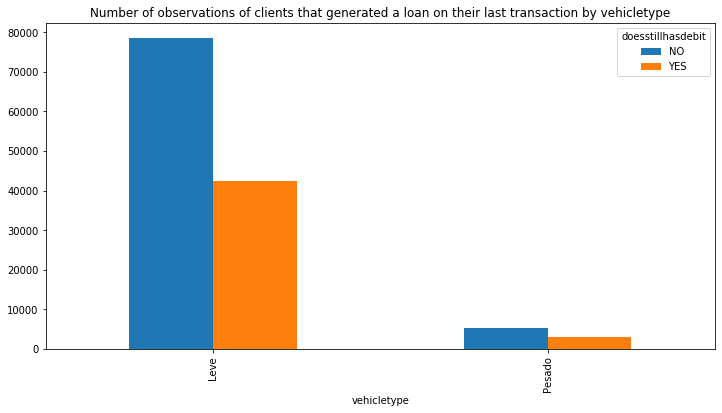

In [129]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'vehicletype'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'vehicletype', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction by vehicletype")
plt.show()

### 5.9 Is there any pattern in vehicle type and axes? 

#### Leve

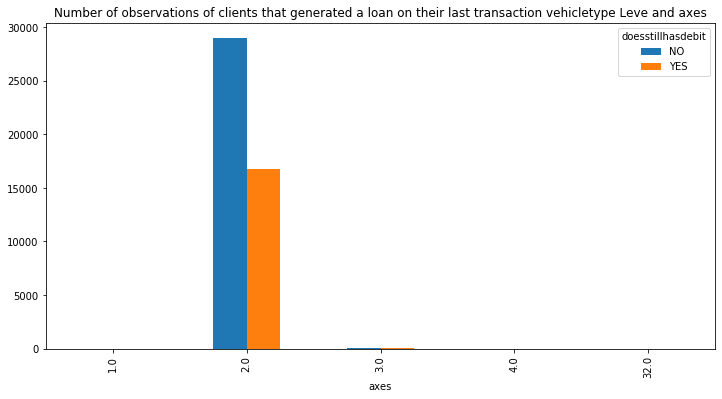

In [131]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO" and vehicletype=="Leve"')
     .groupby(['doesstillhasdebit', 'axes'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'axes', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction vehicletype Leve and axes")
plt.show()

#### Pesado

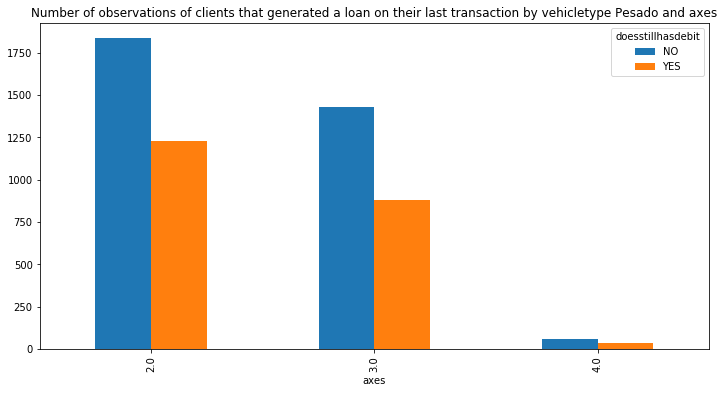

In [132]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO" and vehicletype=="Pesado"')
     .groupby(['doesstillhasdebit', 'axes'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'axes', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction by vehicletype Pesado and axes")
plt.show()

### 5.10 Is there a pattern in Estado Civil?

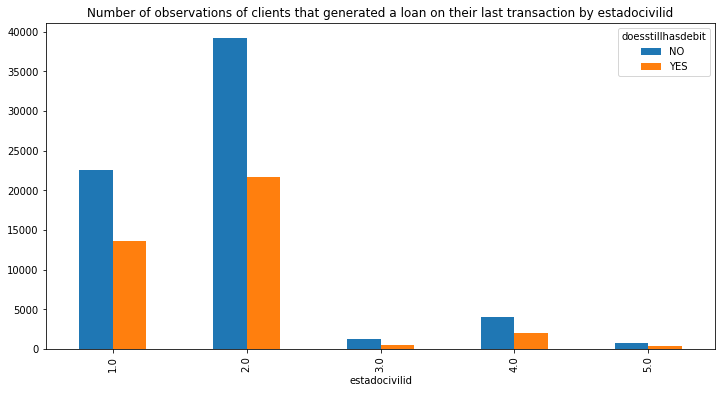

In [133]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'estadocivilid'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'estadocivilid', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction by estadocivilid")
plt.show()

### 5.11 Is there a pattern in Estado?

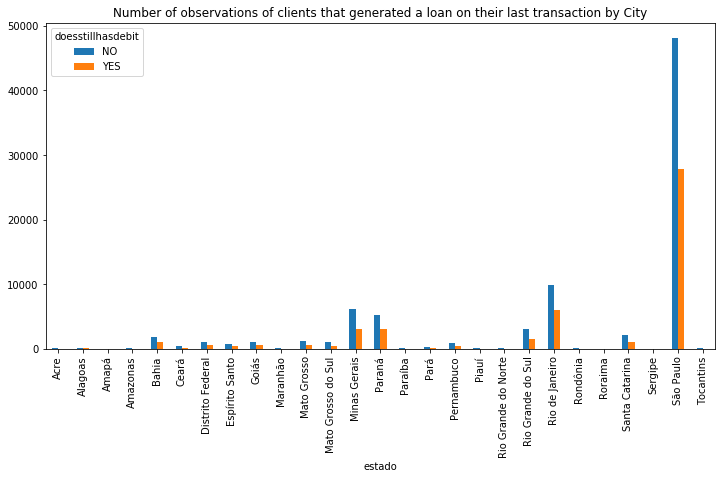

In [134]:
fig, ax = plt.subplots(figsize = (12, 6))
(df_customer_data
     .query('hadcreditavailabel=="NO"')
     .groupby(['doesstillhasdebit', 'estado'])
     ['daysowningloan']
     .size()
     .reset_index()
     .pivot(index = 'estado', columns = 'doesstillhasdebit', values= 'daysowningloan')
     .plot(kind = 'bar', ax = ax )
)
plt.title("Number of observations of clients that generated a loan on their last transaction by City")
plt.show()

### 5.12 When was customer last transaction?

**Observations:**

- Customers that have not used their tag in more than one year can be considered inactive customers. Probably they left the company, they died, they left the country.

In [135]:
df_year_customer_last_transaction = (
    df_customer_data
        [['lasttransaction_year']]
        .groupby('lasttransaction_year')
        .size()
        .reset_index(name = 'n_customers')
)
df_year_customer_last_transaction

lasttransaction_year  n_customers
0                  2019        91370
1                  2020        96941
2                  2021       826773

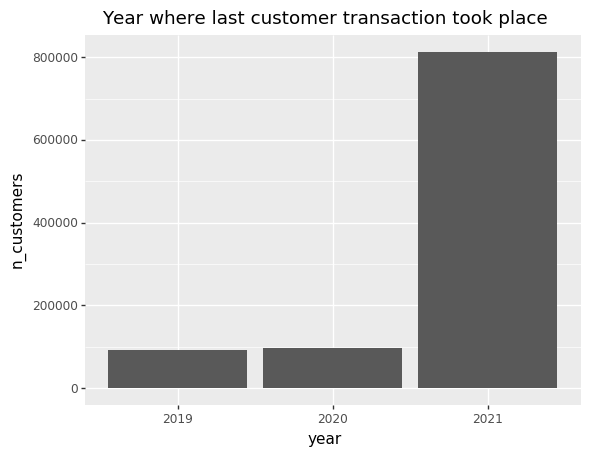

<ggplot: (8763106238337)>

In [124]:
(ggplot( df_year_customer_last_transaction, aes(x = 'factor(lasttransaction_year)', y = 'n_customers')) 
     + geom_col() 
     + labs(title = 'Year where last customer transaction took place', x = 'year')
)

In [125]:
df_year_customer_last_transaction = (
    df_customer_data
        [['lasttransaction_year', 'hadcreditavailabel', 'doesstillhasdebit']]
        .groupby(['lasttransaction_year', 'doesstillhasdebit', 'hadcreditavailabel'])
        .size()
        .reset_index(name = 'n_customers')
)
df_year_customer_last_transaction

lasttransaction_year                      doesstillhasdebit  \
0                  2019  HAD NO DEBITS ON HIS LAST TRANSACTION   
1                  2019                                     NO   
2                  2019                                    YES   
3                  2020  HAD NO DEBITS ON HIS LAST TRANSACTION   
4                  2020                                     NO   
5                  2020                                    YES   
6                  2021  HAD NO DEBITS ON HIS LAST TRANSACTION   
7                  2021                                     NO   
8                  2021                                    YES   

  hadcreditavailabel  n_customers  
0                YES        50585  
1                 NO        25068  
2                 NO        15978  
3                YES        61361  
4                 NO        25679  
5                 NO        10526  
6                YES       759166  
7                 NO        33641  
8                 NO        19389

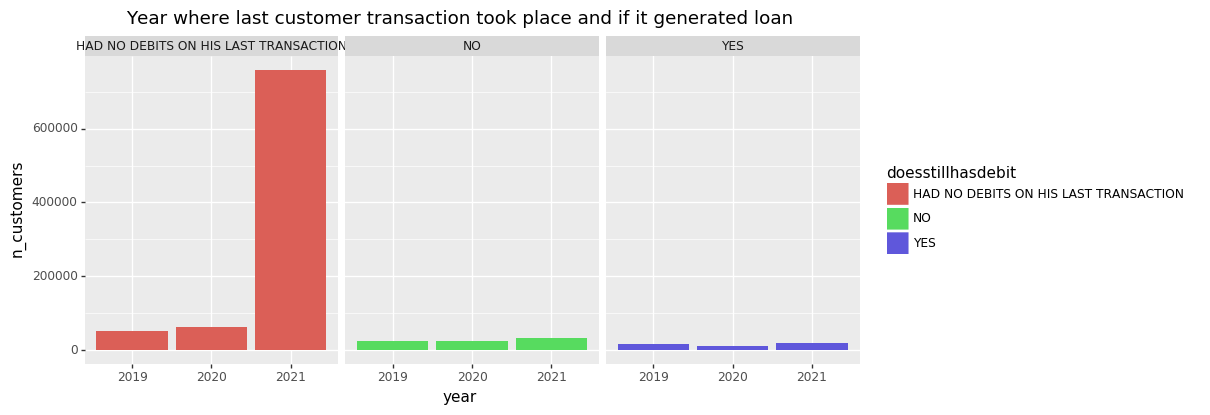

<ggplot: (8763078927609)>

In [126]:
(ggplot( df_year_customer_last_transaction, aes(x = 'factor(lasttransaction_year)', y = 'n_customers', fill = 'doesstillhasdebit')) 
     + geom_col() 
     + facet_wrap('doesstillhasdebit')
     + labs(title = 'Year where last customer transaction took place and if it generated loan', x = 'year')
     + theme(figure_size=(10, 4))
)

### 5.13 How many inactive customers we have?

**Observations:**

* Inactive is considered as last transaction made one year ago.
* We can create a new variable called active or inactive.

In [127]:
df_active_inactive_customers = (
    df_year_customer_last_transaction
     .assign(status = lambda df_ : ['inactive' if year < 2021 else 'active' for year in df_.lasttransaction_year])
     .groupby(['status', 'doesstillhasdebit'])['n_customers']
     .sum()
     .reset_index()
)
df_active_inactive_customers

status                      doesstillhasdebit  n_customers
0    active  HAD NO DEBITS ON HIS LAST TRANSACTION       759166
1    active                                     NO        33641
2    active                                    YES        19389
3  inactive  HAD NO DEBITS ON HIS LAST TRANSACTION       111946
4  inactive                                     NO        50747
5  inactive                                    YES        26504

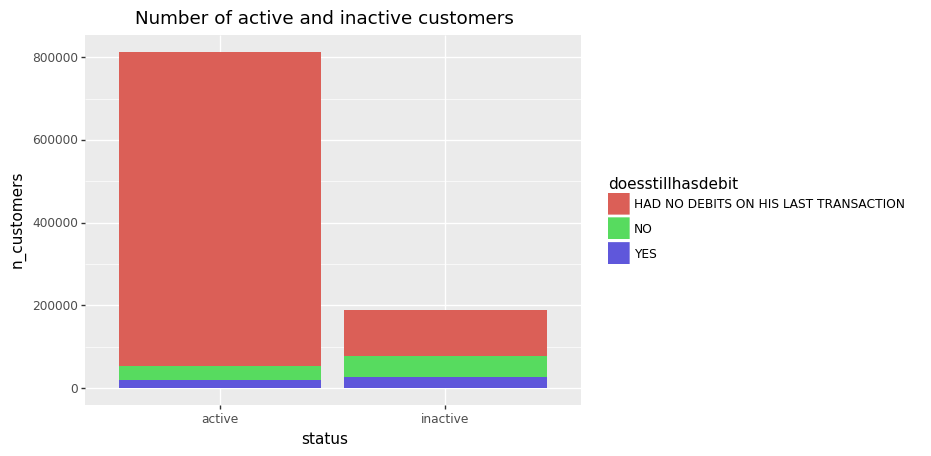

<ggplot: (8763066621297)>

In [128]:
(ggplot( df_active_inactive_customers, aes(x = 'status', y = 'n_customers', fill = 'doesstillhasdebit')) 
    + geom_col()
     + labs(title = 'Number of active and inactive customers')
)

### 5.14 Is there any relationship with plans?

**Observations:**

* Completo, basico and abastece aí are the most important plans. Altough, we are looking just at last transaction.
* In 2021, some plans that appear in a less significant form are rodavia, autocarga, flex, pré-pago empresarial and urbano.

In [136]:
df_last_year_transaction_and_nomeplano = (df_customer_data
    [['lasttransaction_year', 'nomeplano', 'doesstillhasdebit']]
    .groupby(['lasttransaction_year', 'nomeplano', 'doesstillhasdebit'])
    .size()
    .reset_index(name = 'n_customers')
)
df_last_year_transaction_and_nomeplano

lasttransaction_year             nomeplano  \
0                   2019           Abastece Aí   
1                   2019           Abastece Aí   
2                   2019           Abastece Aí   
3                   2019             Autocarga   
4                   2019             Autocarga   
5                   2019             Autocarga   
6                   2019                Básico   
7                   2019                Básico   
8                   2019                Básico   
9                   2019              Completo   
10                  2019              Completo   
11                  2019              Completo   
12                  2019                  Flex   
13                  2019                  Flex   
14                  2019                  Flex   
15                  2019  Pré-Pago Empresarial   
16                  2019  Pré-Pago Empresarial   
17                  2019  Pré-Pago Empresarial   
18                  2019               Rodovia   
19                  2019               Rodovia   
20                  2019               Rodovia   
21                  2019                Urbano   
22                  2019                Urbano   
23                  2019                Urbano   
24                  2020           Abastece Aí   
25                  2020           Abastece Aí   
26                  2020           Abastece Aí   
27                  2020             Autocarga   
28                  2020             Autocarga   
29                  2020             Autocarga   
30                  2020                Básico   
31                  2020                Básico   
32                  2020                Básico   
33                  2020              Completo   
34                  2020              Completo   
35                  2020              Completo   
36                  2020                  Flex   
37                  2020                  Flex   
38                  2020                  Flex   
39                  2020  Pré-Pago Empresarial   
40                  2020  Pré-Pago Empresarial   
41                  2020  Pré-Pago Empresarial   
42                  2020               Rodovia   
43                  2020               Rodovia   
44                  2020               Rodovia   
45                  2020                Urbano   
46                  2020                Urbano   
47                  2020                Urbano   
48                  2021           Abastece Aí   
49                  2021           Abastece Aí   
50                  2021           Abastece Aí   
51                  2021             Autocarga   
52                  2021             Autocarga   
53                  2021             Autocarga   
54                  2021                Básico   
55                  2021                Básico   
56                  2021                Básico   
57                  2021              Completo   
58                  2021              Completo   
59                  2021              Completo   
60                  2021                  Fiat   
61                  2021                  Fiat   
62                  2021                  Fiat   
63                  2021                  Flex   
64                  2021                  Flex   
65                  2021                  Flex   
66                  2021              Locadora   
67                  2021  Pré-Pago Empresarial   
68                  2021  Pré-Pago Empresarial   
69                  2021  Pré-Pago Empresarial   
70                  2021  Pós-Pago Empresarial   
71                  2021  Pós-Pago Empresarial   
72                  2021               Rodovia   
73                  2021               Rodovia   
74                  2021               Rodovia   
75                  2021                Urbano   
76                  2021                Urbano   
77                  2021                Urbano   

                        doesstillhasdebit  n_customer

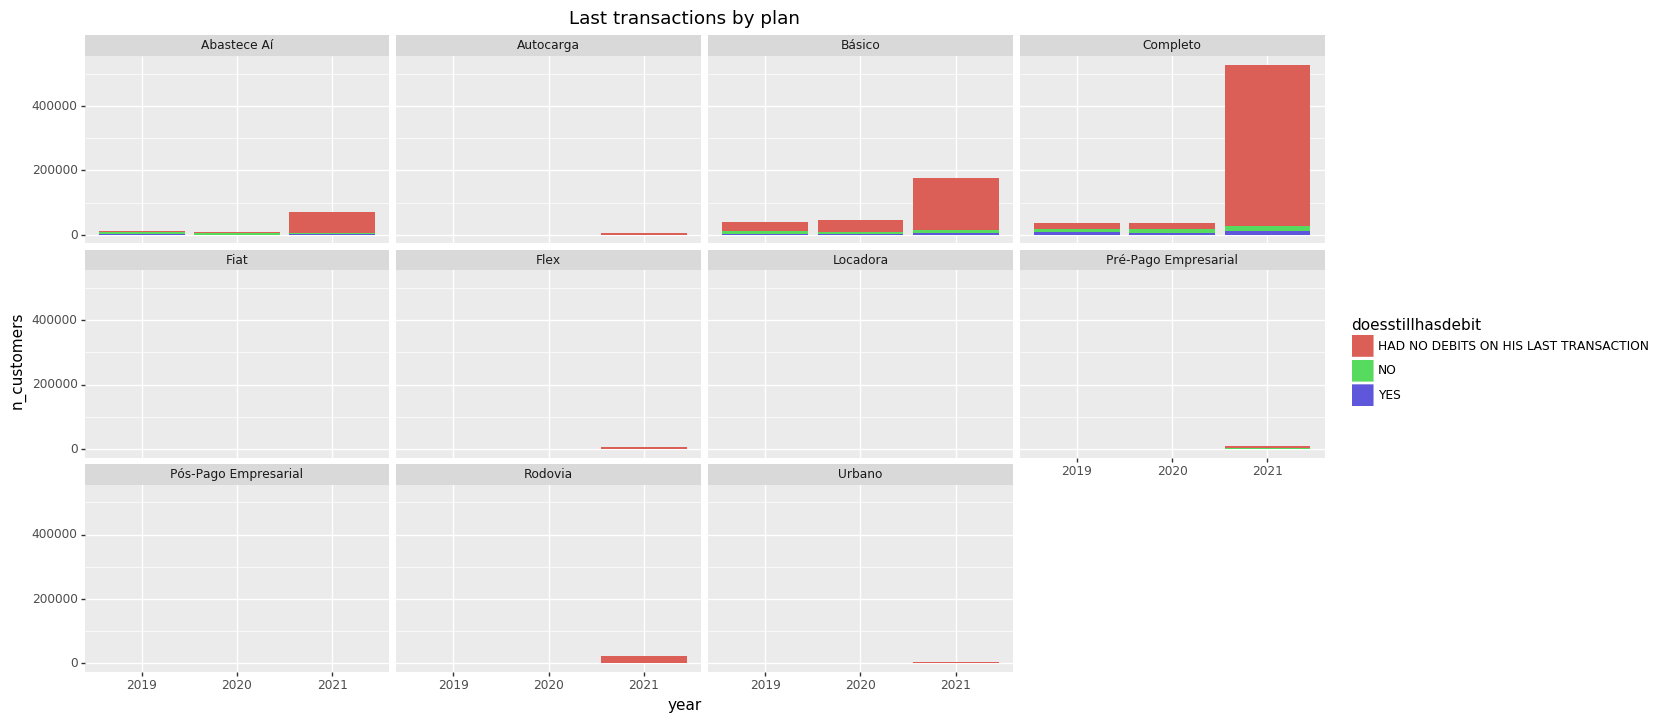

<ggplot: (8744061703281)>

In [137]:
(ggplot(df_last_year_transaction_and_nomeplano, aes(x= 'factor(lasttransaction_year)', y = 'n_customers', fill = 'doesstillhasdebit'))
     + geom_col()
     + facet_wrap('nomeplano')
     + labs(title = 'Last transactions by plan', x = 'year')
     + theme(figure_size=(16, 8))
)

In [138]:
df_customer_data.head()

clienteid  transacaoid     lasttransactiondate  adesaoid  \
0      20501    284554493 2019-08-19 08:42:04.487   2365465   
1     178183    290755949 2019-09-14 14:20:17.000   3071191   
2      15517    517271815 2021-11-26 21:20:49.000   3148190   
3     406190    366114506 2020-07-16 00:51:55.000   2378348   
4     447560    524129213 2021-12-14 20:37:19.000   4562063   

   lasttransactionvalue    saldoid hadcreditavailabel  \
0                   2.1    91774.0                YES   
1                  10.0   268147.0                 NO   
2                   0.0    86885.0                YES   
3                   7.6  1662447.0                 NO   
4                  12.0  3121784.0                YES   

   dayswithcreditavailabel  balancebeforelasttransaction  tipooperacaoid  \
0                    612.0                         23.12               7   
1                      0.0                          9.15              14   
2                    331.0                         49.55              14   
3                      0.0                          3.00               7   
4                    193.0                         33.44              14   

  operationtype vehicletype  axes  actualbalance  lastrechargevalue  \
0       HIGHWAY        Leve   NaN          21.02               50.0   
1          None        Leve   NaN          -0.85               50.0   
2          None        Leve   2.0          49.55              100.0   
3       HIGHWAY        Leve   NaN          -4.60              220.0   
4          None        Leve   NaN          25.12               50.0   

         lastrechargedate methodofpayment  daysowningloan  \
0 2019-05-31 17:42:51.173          OTHERS               0   
1 2019-09-13 18:49:16.433          OTHERS             824   
2 2021-10-29 22:59:33.740          OTHERS               0   
3 2017-12-21 15:00:38.107          OTHERS             518   
4 2021-12-14 20:38:04.930          OTHERS               0   

                       doesstillhasdebit data_nascimento  customerage  sexoid  \
0  HAD NO DEBITS ON HIS LAST TRANSACTION      1977-10-11         44.0     1.0   
1                                     NO      1989-05-07         32.0     1.0   
2  HAD NO DEBITS ON HIS LAST TRANSACTION      1978-07-26         43.0     1.0   
3                                     NO      1977-10-22         44.0     1.0   
4  HAD NO DEBITS ON HIS LAST TRANSACTION      1979-04-30         42.0     1.0   

   estadocivilid     estado nomeplano  pessoa_fisica  totalloans  \
0            5.0  São Paulo    Básico           True         NaN   
1            2.0  São Paulo    Básico           True         NaN   
2            2.0  São Paulo    Básico           True         3.0   
3            2.0  São Paulo    Básico           True         NaN   
4            2.0  São Paulo    Básico           True         NaN   

   avgdayspayback  totalloans_highway  totaloans_parkinglot  \
0             NaN                 NaN                   NaN   
1             NaN                 NaN                   NaN   
2            70.0                 3.0                   0.0   
3             NaN                 NaN                   NaN   
4             NaN                 NaN                   NaN   

   totalloans_membershipsubscription  totaltransactions  \
0                                NaN                121   
1                                NaN                 27   
2                                0.0                147   
3                                NaN                  1   
4                                NaN                146   

   totaltransactions_highway  totatransactions_parkinglot  \
0                        121                            0   
1                         23                            0   
2                        142                            1   
3                          1                            0   
4                        130                            1   

   totaltransactions_membershipsu

### 5.15 Is there any relationship with vehicle category?


In [139]:
df_last_customer_transaction_by_category = (
    df_customer_data
        [['lasttransaction_year', 'vehicletype', 'doesstillhasdebit']]
        .groupby(['lasttransaction_year', 'vehicletype', 'doesstillhasdebit'])
        .size()
        .reset_index(name = 'n_customers')
)
df_last_customer_transaction_by_category.head()

lasttransaction_year vehicletype                      doesstillhasdebit  \
0                  2019        Leve  HAD NO DEBITS ON HIS LAST TRANSACTION   
1                  2019        Leve                                     NO   
2                  2019        Leve                                    YES   
3                  2019      Pesado  HAD NO DEBITS ON HIS LAST TRANSACTION   
4                  2019      Pesado                                     NO   

   n_customers  
0        48812  
1        23808  
2        14464  
3         1553  
4         1233

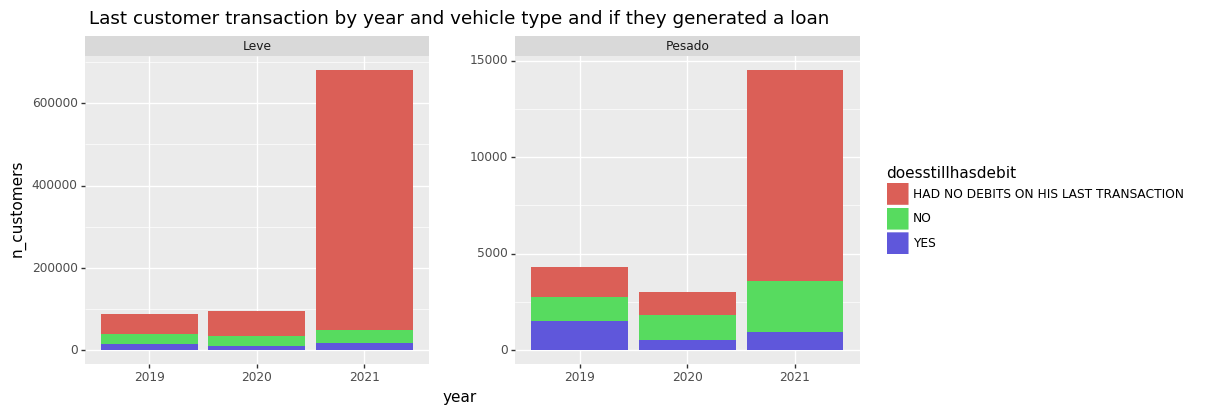

<ggplot: (8744076692081)>

In [140]:
(ggplot(df_last_customer_transaction_by_category, aes(x = 'factor(lasttransaction_year)', y = 'n_customers', fill = 'doesstillhasdebit')) 
     + geom_col() 
     + facet_wrap('vehicletype', scales = 'free')
     + labs(title = 'Last customer transaction by year and vehicle type and if they generated a loan', x = 'year')
     + theme(figure_size=(10, 4))
     + theme(subplots_adjust={'wspace': 0.25})
)

In [141]:
df_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015084 entries, 0 to 1015083
Data columns (total 38 columns):
 #   Column                                    Non-Null Count    Dtype         
---  ------                                    --------------    -----         
 0   clienteid                                 1015084 non-null  int64         
 1   transacaoid                               1015084 non-null  int64         
 2   lasttransactiondate                       1015084 non-null  datetime64[ns]
 3   adesaoid                                  1015084 non-null  int64         
 4   lasttransactionvalue                      1015084 non-null  float64       
 5   saldoid                                   970535 non-null   float64       
 6   hadcreditavailabel                        1015084 non-null  object        
 7   dayswithcreditavailabel                   947306 non-null   float64       
 8   balancebeforelasttransaction              1015084 non-null  float64       
 9   ti

### 5.16 Is there any relationship between age and loan status on last transaction?

Observations:

* Inactive users does cause noise.
* Age variable has to be cleaned.
    - Missing value should be imputed.


In [142]:
df_customers_by_age_and_loan_status = (df_customer_data
    .query('customerage >= 18')
    .assign(status = lambda df_ : ['inactive' if year < 2021 else 'active' for year in df_.lasttransaction_year])                                   
    .filter(['customerage', 'doesstillhasdebit', 'status'])
    .assign(customerage = lambda df_: df_.customerage.astype('int64').clip(lower = 18, upper = 90))
    .groupby(['customerage', 'doesstillhasdebit', 'status'])
    .size()
    .reset_index(name = 'n_customers')
)

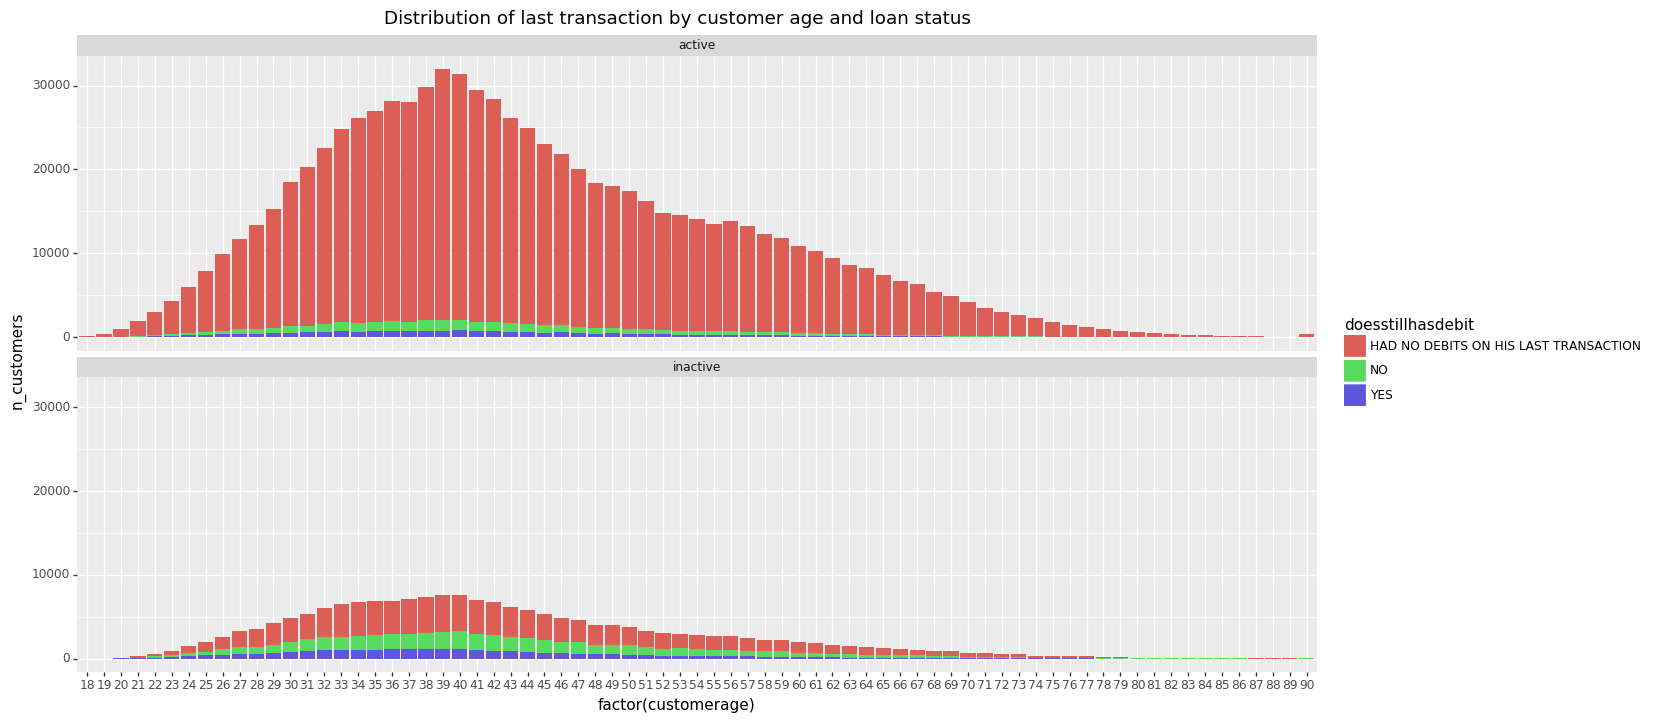

<ggplot: (8744057231269)>

In [143]:
(ggplot(df_customers_by_age_and_loan_status, aes(x = 'factor(customerage)', y = 'n_customers', fill = 'doesstillhasdebit')) 
     + geom_col()
     + facet_wrap('status', ncol = 1)
     + labs(title = 'Distribution of last transaction by customer age and loan status')
     + theme(figure_size=(16, 8))
)

### 5.17 Is there any relationship between age, plan and loan status?

**Observations:**

* Between age and plans theres is not a clear relationship.
* Age and account status matters in terms of frequencies.

In [144]:
df_customers_by_age_and_loan_status = (df_customer_data
    .assign(status = lambda df_ : ['inactive' if year < 2021 else 'active' for year in df_.lasttransaction_year]) 
    .query('customerage >= 18 and status == "active"')
    .filter(['customerage', 'doesstillhasdebit', 'status', 'nomeplano'])
    .assign(customerage = lambda df_: df_.customerage.astype('int64').clip(lower = 18, upper = 90))
    .groupby(['customerage', 'doesstillhasdebit', 'status', 'nomeplano'])
    .size()
    .reset_index(name = 'n_customers')
)
df_customers_by_age_and_loan_status

customerage                      doesstillhasdebit  status  nomeplano  \
0              18  HAD NO DEBITS ON HIS LAST TRANSACTION  active     Básico   
1              18  HAD NO DEBITS ON HIS LAST TRANSACTION  active   Completo   
2              18  HAD NO DEBITS ON HIS LAST TRANSACTION  active       Fiat   
3              18  HAD NO DEBITS ON HIS LAST TRANSACTION  active    Rodovia   
4              18  HAD NO DEBITS ON HIS LAST TRANSACTION  active     Urbano   
...           ...                                    ...     ...        ...   
1394           90                                     NO  active     Básico   
1395           90                                     NO  active   Completo   
1396           90                                    YES  active  Autocarga   
1397           90                                    YES  active     Básico   
1398           90                                    YES  active   Completo   

      n_customers  
0              12  
1              69  
2               2  
3               5  
4               1  
...           ...  
1394            3  
1395            7  
1396            2  
1397            1  
1398            3  

[1399 rows x 5 columns]

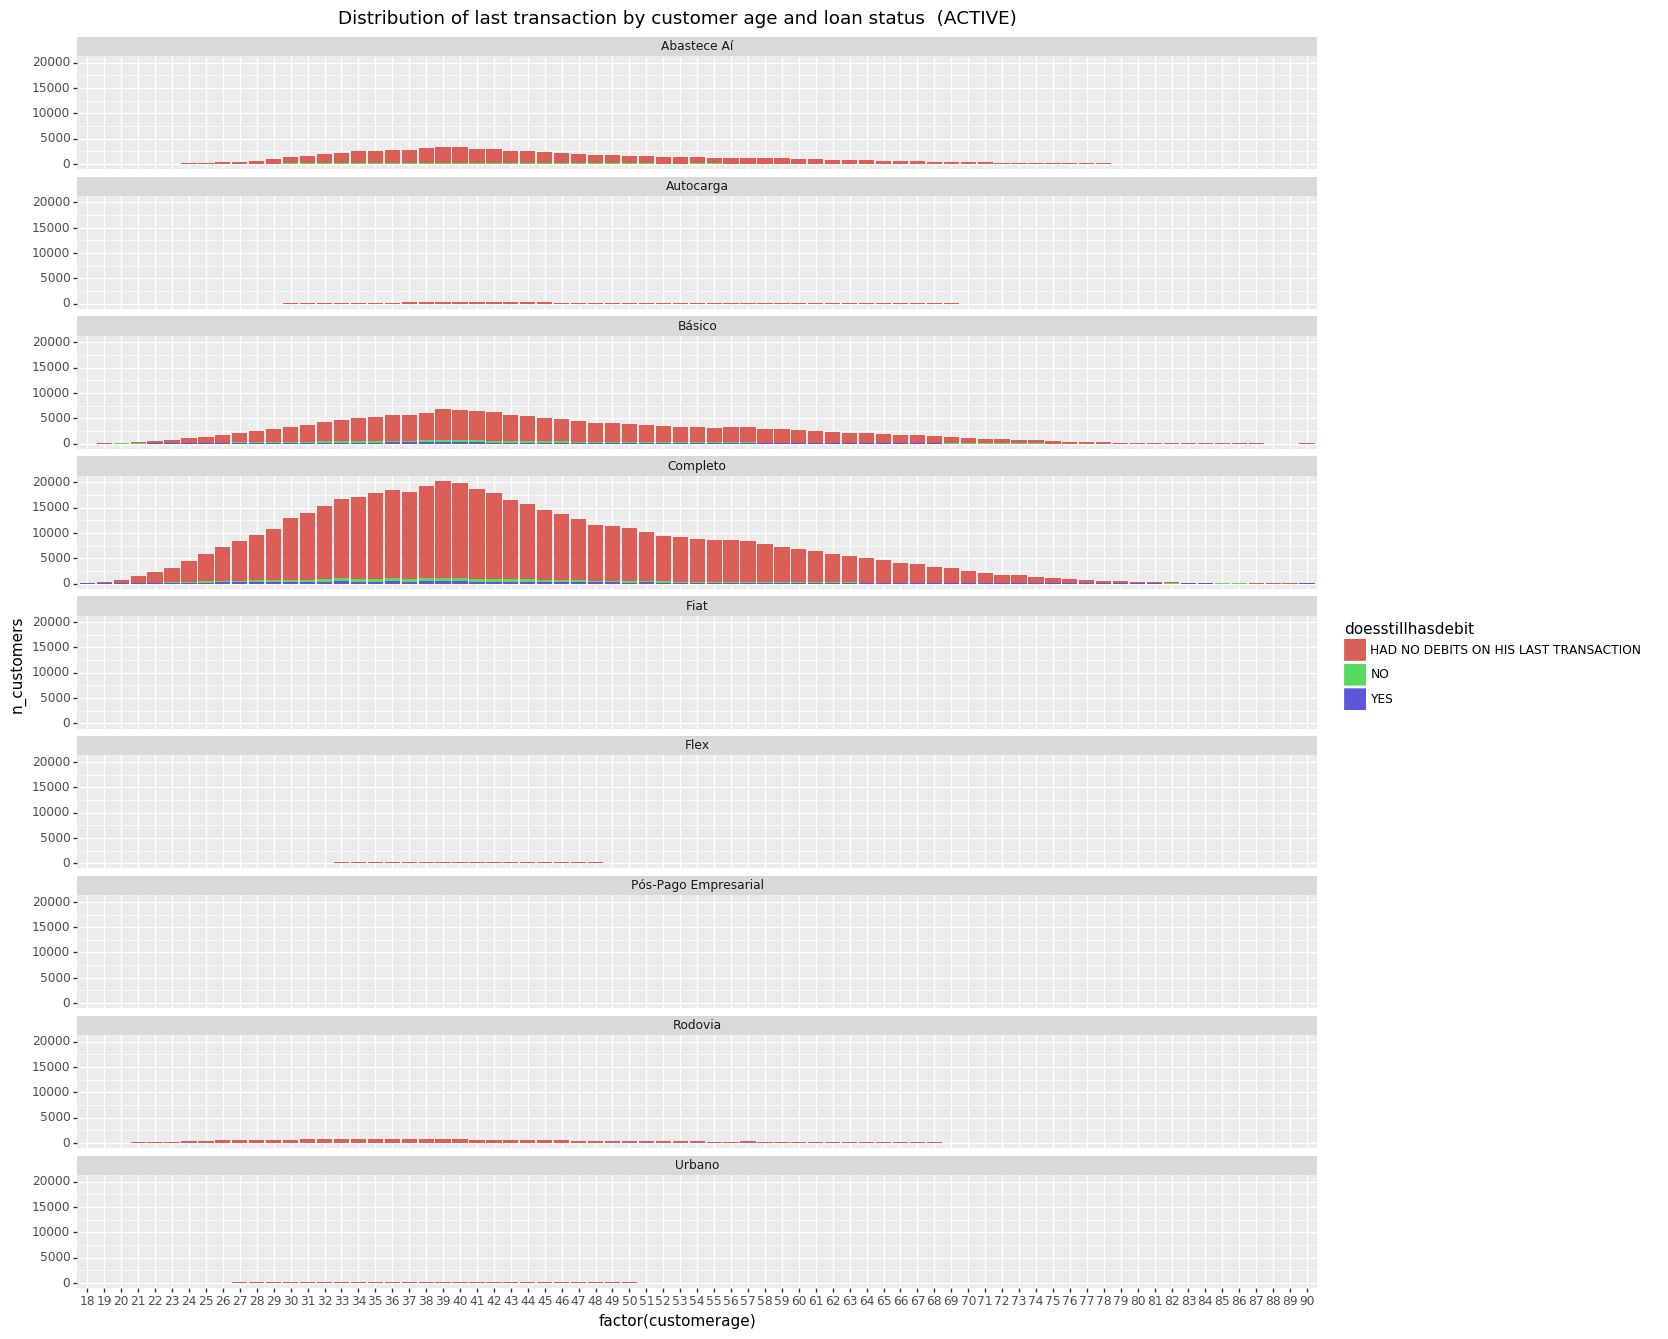

<ggplot: (8744087081513)>

In [145]:
(ggplot(df_customers_by_age_and_loan_status, aes(x = 'factor(customerage)', y = 'n_customers', fill = 'doesstillhasdebit')) 
     + geom_col()
     + facet_wrap('~nomeplano', ncol = 1)
     + labs(title = 'Distribution of last transaction by customer age and loan status  (ACTIVE)')
     + theme(figure_size=(16, 16))
)

In [146]:
df_customers_by_age_and_loan_status = (df_customer_data
    .assign(status = lambda df_ : ['inactive' if year < 2021 else 'active' for year in df_.lasttransaction_year]) 
    .query('customerage >= 18 and status == "inactive"')
    .filter(['customerage', 'doesstillhasdebit', 'status', 'nomeplano'])
    .assign(customerage = lambda df_: df_.customerage.astype('int64').clip(lower = 18, upper = 90))
    .groupby(['customerage', 'doesstillhasdebit', 'status', 'nomeplano'])
    .size()
    .reset_index(name = 'n_customers')
)
df_customers_by_age_and_loan_status

customerage                      doesstillhasdebit    status  \
0              19  HAD NO DEBITS ON HIS LAST TRANSACTION  inactive   
1              19  HAD NO DEBITS ON HIS LAST TRANSACTION  inactive   
2              19                                     NO  inactive   
3              19                                    YES  inactive   
4              20  HAD NO DEBITS ON HIS LAST TRANSACTION  inactive   
...           ...                                    ...       ...   
1252           90                                     NO  inactive   
1253           90                                     NO  inactive   
1254           90                                    YES  inactive   
1255           90                                    YES  inactive   
1256           90                                    YES  inactive   

        nomeplano  n_customers  
0          Básico            1  
1        Completo            4  
2        Completo            2  
3        Completo            1  
4          Básico           39  
...           ...          ...  
1252       Básico            9  
1253     Completo           20  
1254  Abastece Aí            1  
1255       Básico            3  
1256     Completo            2  

[1257 rows x 5 columns]

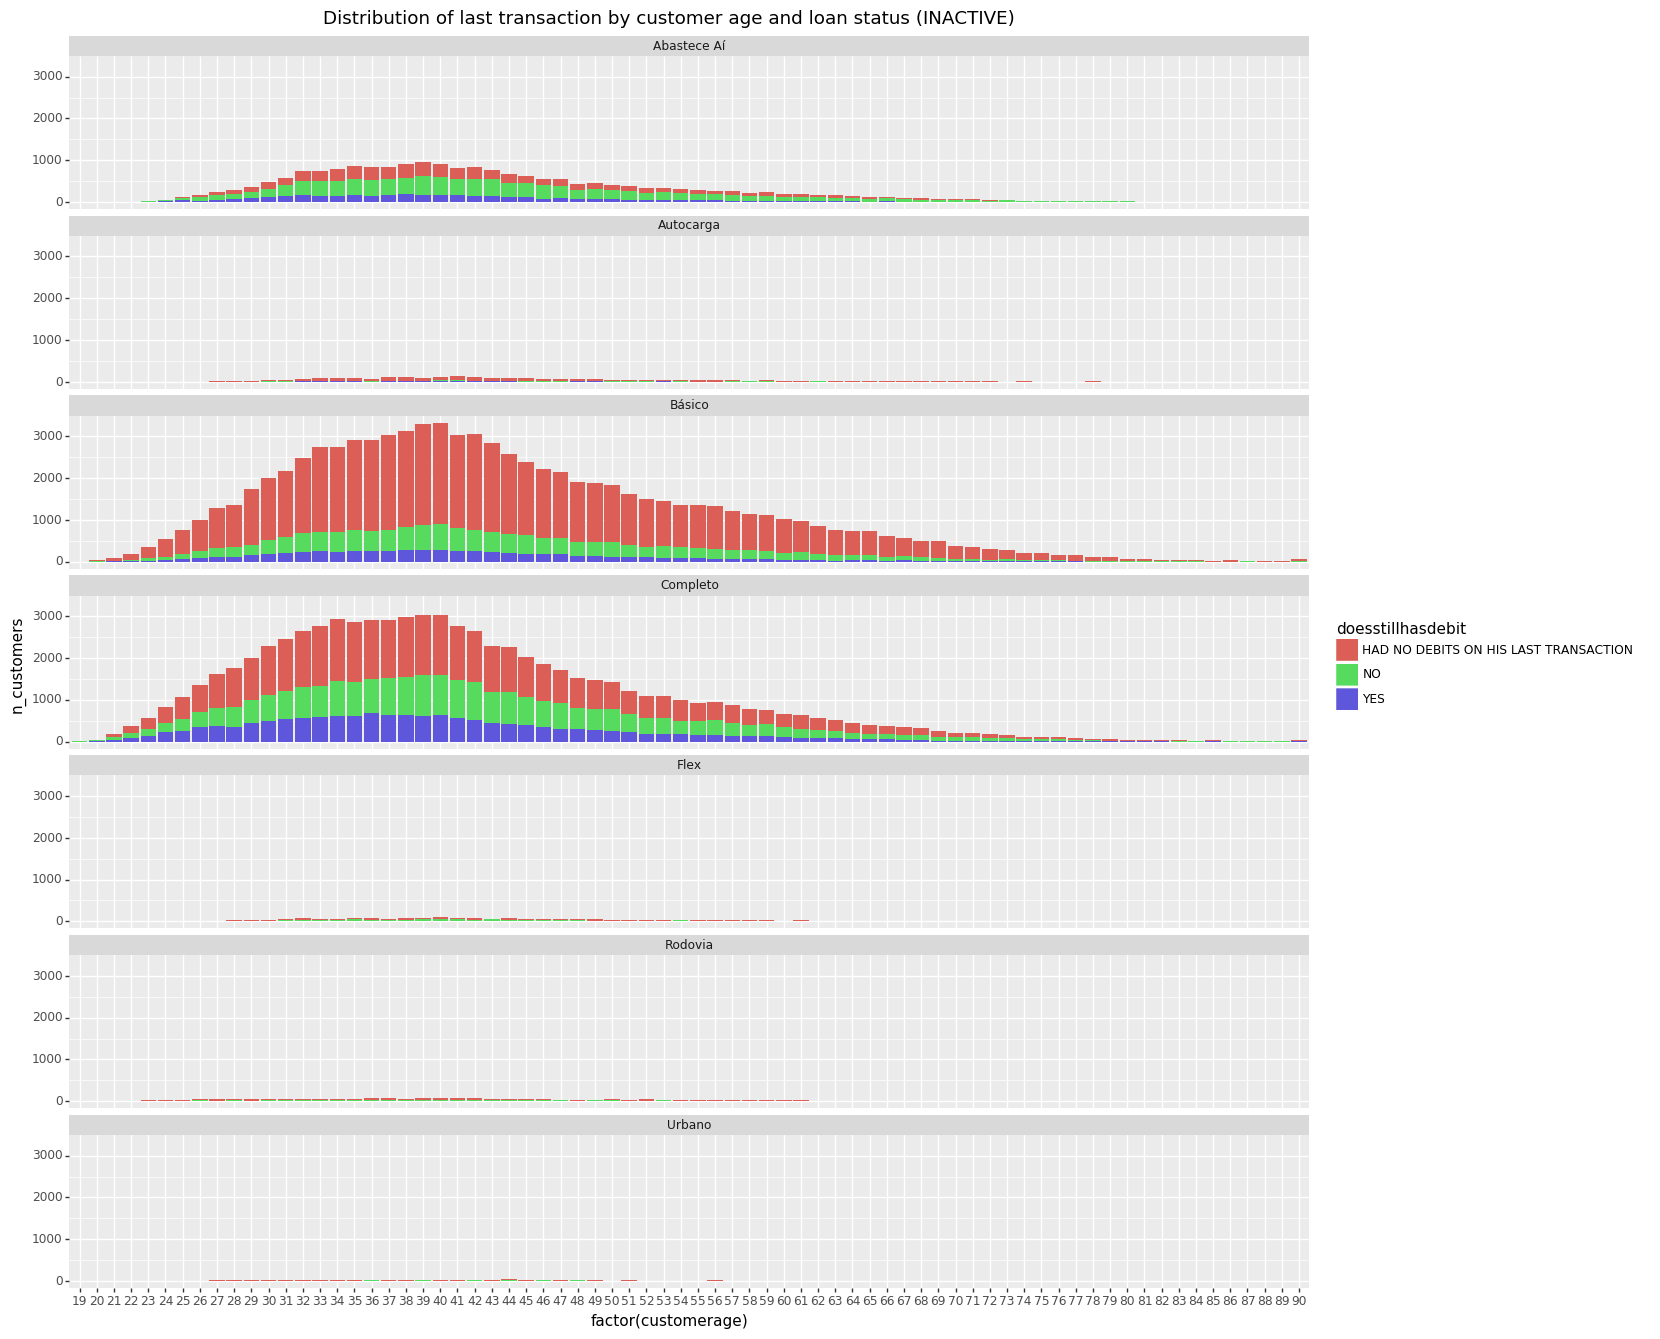

<ggplot: (8744142747749)>

In [147]:
(ggplot(df_customers_by_age_and_loan_status, aes(x = 'factor(customerage)', y = 'n_customers', fill = 'doesstillhasdebit')) 
     + geom_col()
     + facet_wrap('~nomeplano', ncol = 1)
     + labs(title = 'Distribution of last transaction by customer age and loan status (INACTIVE)')
     + theme(figure_size=(16, 16))
)